In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
#Data preprocessing
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [3]:
#Models and their evaluations
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix, classification_report, f1_score, make_scorer, precision_score, recall_score
from sklearn.metrics import balanced_accuracy_score as accuracy_score
import lightgbm as lgb
from catboost import CatBoostClassifier
from xgboost import XGBClassifier as xgb
import xgboost
import optuna
from sklearn.model_selection import StratifiedKFold

In [4]:
#visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
#other important librares
import numpy as np
import shap
import glob
import os
from joblib import dump, load

# WEB-IDS23 Dataset

### Mix into one file

In [6]:
data_folder = "csv/web-ids23/"

file_names = [
    "web-ids23_bruteforce_http.csv",
    "web-ids23_bruteforce_https.csv",
    "web-ids23_dos_https.csv",
    "web-ids23_portscan.csv",
    "web-ids23_sql_injection_http.csv",
    "web-ids23_sql_injection_https.csv",
    "web-ids23_ssh_login.csv",
    "web-ids23_ssh_login_successful.csv",
    "web-ids23_ssrf_http.csv",
    "web-ids23_ssrf_https.csv",
    "web-ids23_xss_http.csv",
    "web-ids23_xss_https.csv",
    "web-ids23_revshell_http.csv",
    "web-ids23_revshell_https.csv",
    "web-ids23_smtp_enum.csv",
    "web-ids23_smtp_version.csv",
    "web-ids23_hostsweep_Pn.csv",
    "web-ids23_hostsweep_sn.csv",
    "web-ids23_ftp_login.csv",
    "web-ids23_ftp_version.csv",
    "web-ids23_dos_http.csv"
]

dataframes = []
min_rows = 100
    
for file in file_names:
    df = pd.read_csv(os.path.join(data_folder, file))
    df_sampled = df.sample(n=min(min_rows,len(df)), random_state=42) 
    dataframes.append(df_sampled)
    
df = pd.read_csv(os.path.join(data_folder, "web-ids23_benign.csv"))
df_sampled = df.sample(n=min(8000,len(df)), random_state=42) 
dataframes.append(df_sampled)

combined_df = pd.concat(dataframes, ignore_index=True)

output_path = "csv\\webids23.csv"
combined_df.to_csv(output_path, index=False)


In [7]:
len(combined_df)

10007

In [8]:
#Data pre-processing
file_path = 'csv\\webids23.csv'
data = pd.read_csv(file_path)

label_encoder = LabelEncoder()
data['attack'] = label_encoder.fit_transform(data['attack'])
data['id.orig_h'] = label_encoder.fit_transform(data['id.orig_h'])  
data['id.resp_h'] = label_encoder.fit_transform(data['id.resp_h']) 
data['service'] = label_encoder.fit_transform(data['service']) 
data['traffic_direction'] = label_encoder.fit_transform(data['traffic_direction']) 


features = [
    'id.orig_h',
    'id.resp_h',
    'service',
    'flow_duration',
    'fwd_pkts_tot',
    'bwd_pkts_tot',
    'fwd_data_pkts_tot',
    'bwd_data_pkts_tot',
    'fwd_pkts_per_sec',
    'bwd_pkts_per_sec',
    'flow_pkts_per_sec',
    'down_up_ratio',
    'fwd_header_size_tot',
    'fwd_header_size_min',
    'fwd_header_size_max',
    'bwd_header_size_tot',
    'bwd_header_size_min',
    'bwd_header_size_max',
    'flow_FIN_flag_count',
    'flow_SYN_flag_count',
    'flow_RST_flag_count',
    'fwd_PSH_flag_count',
    'bwd_PSH_flag_count',
    'flow_ACK_flag_count',
    'fwd_URG_flag_count',
    'bwd_URG_flag_count',
    'flow_CWR_flag_count',
    'flow_ECE_flag_count',
    'payload_bytes_per_second',
    'fwd_init_window_size',
    'bwd_init_window_size',
    'fwd_last_window_size',
    'bwd_last_window_size',
    'traffic_direction'
]
X = data[features]
y = data['attack']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Accuracy: 0.9813059701492537
Confusion Matrix: [[ 393    9]
 [  24 1576]]


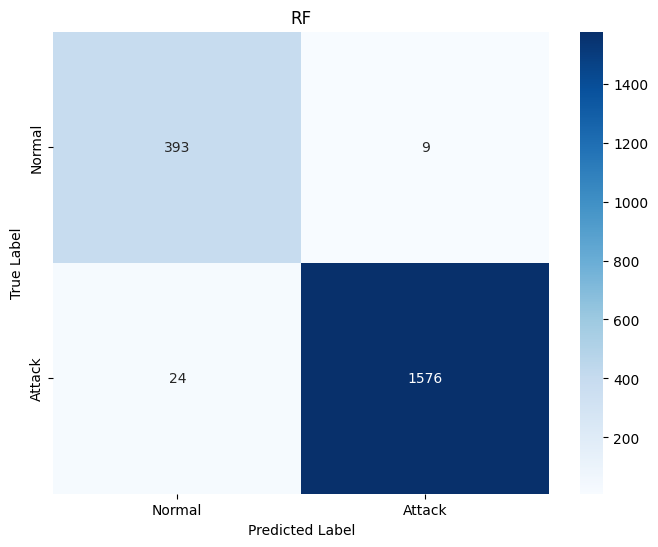

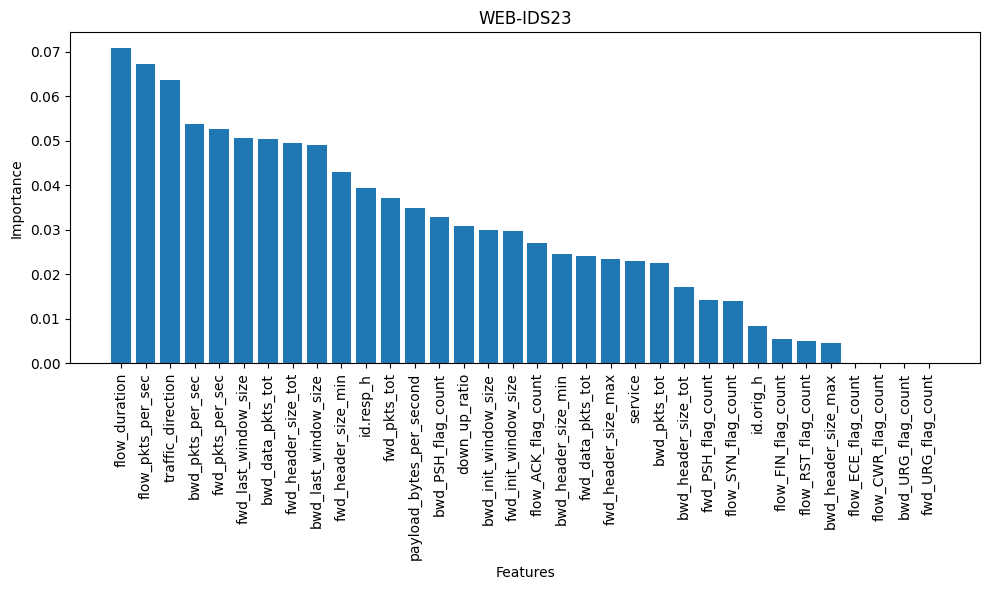

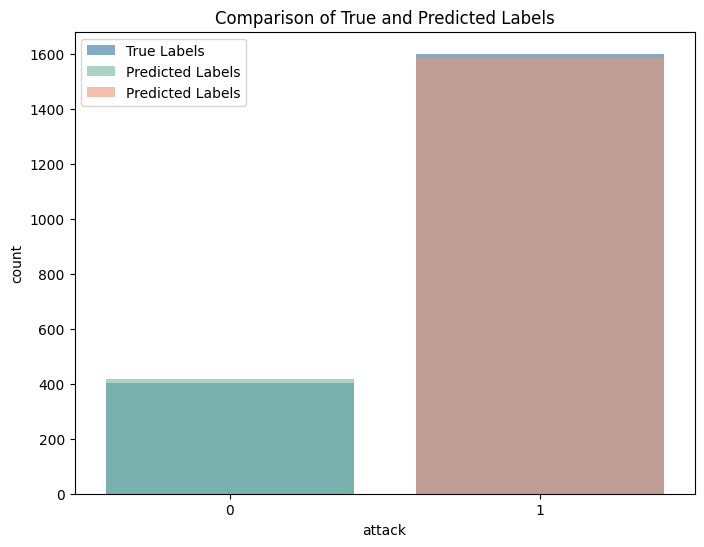

In [9]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

#Results
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

#Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("RF")
plt.show()

feature_importances = clf.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.title("WEB-IDS23")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x=y_test, label="True Labels", alpha=0.6)
sns.countplot(x=y_pred, label="Predicted Labels", alpha=0.6, palette="Set2")
plt.legend()
plt.title("Comparison of True and Predicted Labels")
plt.show()

In [10]:
del clf

### Read and pre-proccess the united dataset

In [11]:
#Data pre-processing
file_path = 'csv\\webids23.csv'
data = pd.read_csv(file_path)

label_encoder = LabelEncoder()
data['attack'] = label_encoder.fit_transform(data['attack'])

features = ['flow_duration', 'flow_pkts_per_sec','bwd_data_pkts_tot','fwd_pkts_tot','fwd_header_size_tot']

X = data[features]
y = data['attack']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Random Forest

In [12]:
#Random Forest
param_grid = {
    'n_estimators': [10, 30, 50, 100, 200],
    'max_depth': [None, 10, 20, 30, 50], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4], 
    'max_features': ['sqrt', 'log2', None]
}

rf_model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='balanced_accuracy', cv=5, verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)

optimized_rf_model = RandomForestClassifier(**best_params, random_state=42)
optimized_rf_model.fit(X_train, y_train)

y_pred = optimized_rf_model.predict(X_test)

Fitting 5 folds for each of 675 candidates, totalling 3375 fits
Best Parameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 30}
Best Cross-Validation Accuracy: 0.953390284267913


In [13]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

Accuracy: 0.9588805970149253
Confusion Matrix: [[ 381   21]
 [  48 1552]]


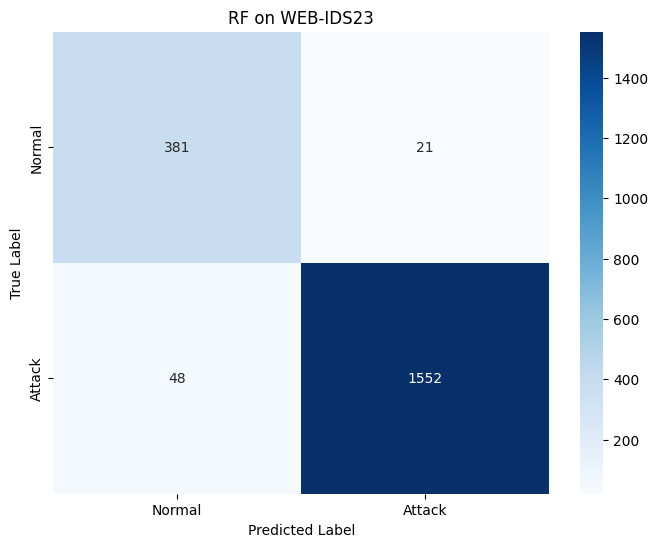

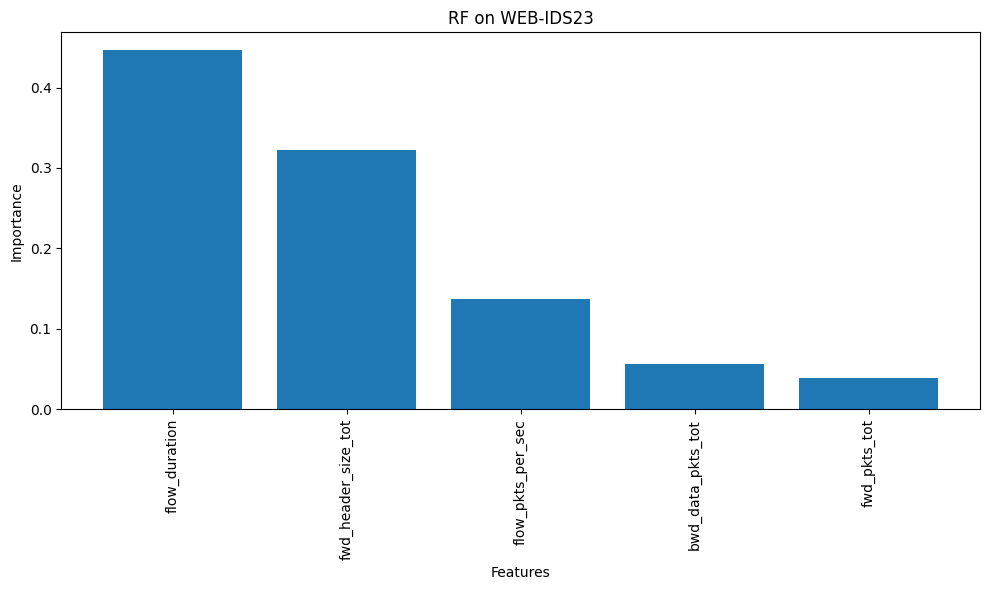

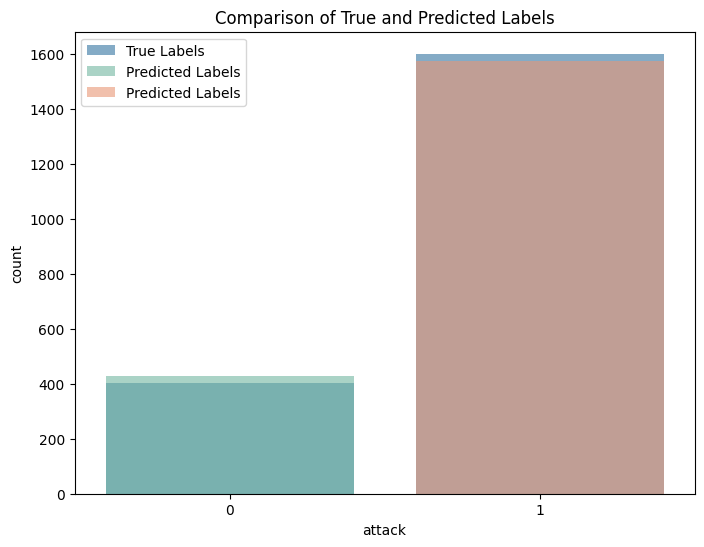

In [14]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("RF on WEB-IDS23")
plt.show()

feature_importances = optimized_rf_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.title("RF on WEB-IDS23")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x=y_test, label="True Labels", alpha=0.6)
sns.countplot(x=y_pred, label="Predicted Labels", alpha=0.6, palette="Set2")
plt.legend()
plt.title("Comparison of True and Predicted Labels")
plt.show()

In [15]:
dump(optimized_rf_model, "models\\rf_model.joblib", compress=("xz", 3))

['models\\rf_model.joblib']

In [16]:
del rf_model

### Support Vector Machine

In [17]:
#SVM
svm_model = SVC(kernel='linear', random_state=42) 
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

In [18]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

Accuracy: 0.8221595149253731
Confusion Matrix: [[ 306   96]
 [ 187 1413]]


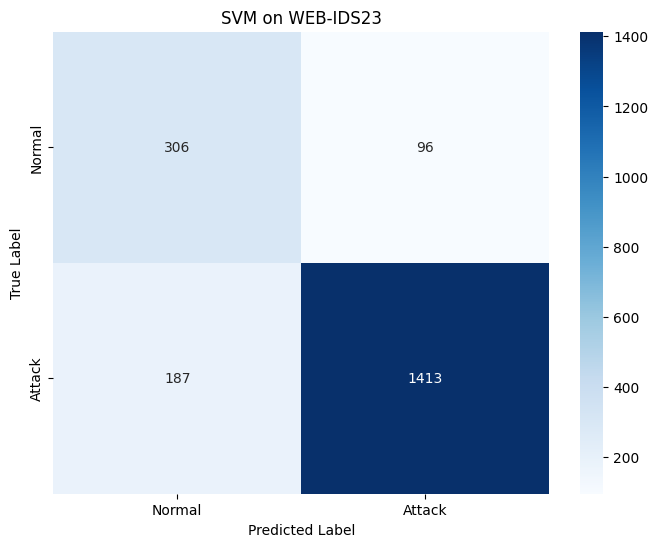

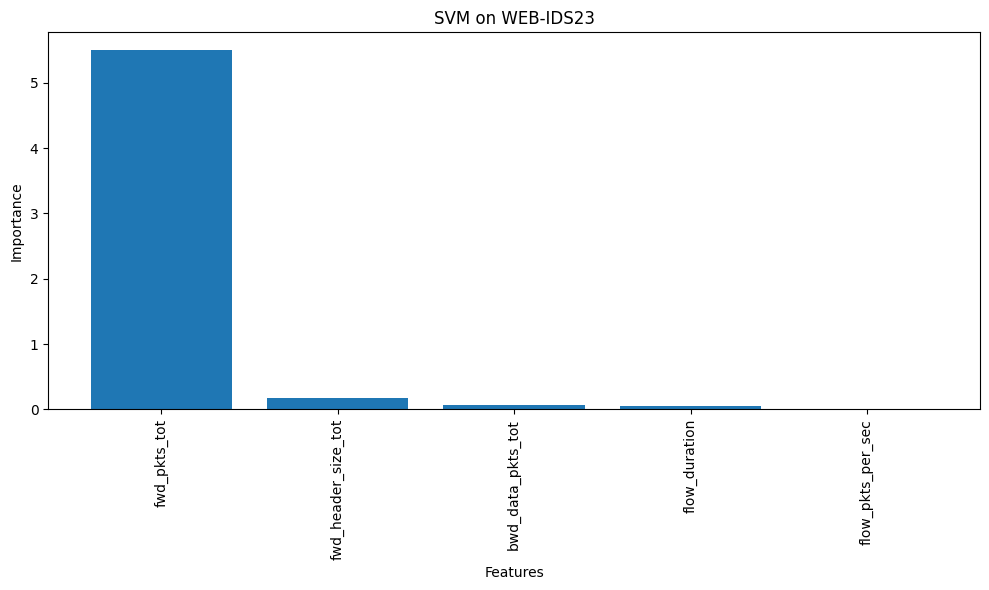

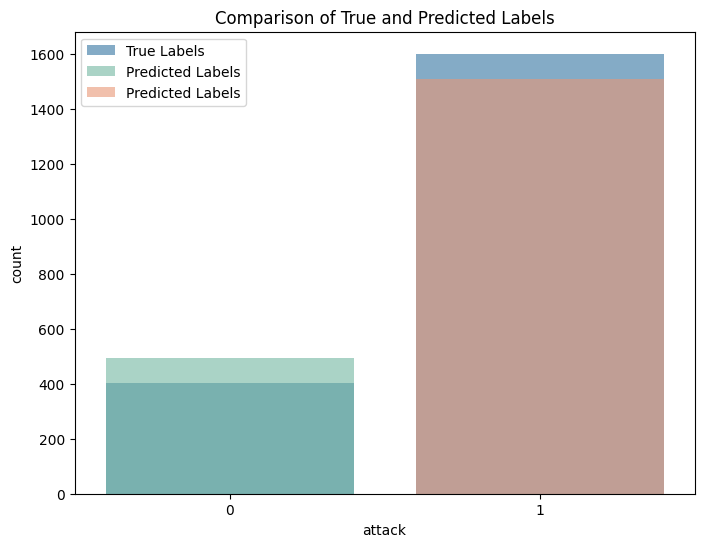

In [19]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("SVM on WEB-IDS23")
plt.show()

feature_importances = np.abs(svm_model.coef_[0])
indices = np.argsort(feature_importances)[::-1]
#features = X_train.columns if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.title("SVM on WEB-IDS23")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x=y_test, label="True Labels", alpha=0.6)
sns.countplot(x=y_pred, label="Predicted Labels", alpha=0.6, palette="Set2")
plt.legend()
plt.title("Comparison of True and Predicted Labels")
plt.show()

In [20]:
dump(svm_model, "models\\svm_model.joblib", compress=("xz", 3))

['models\\svm_model.joblib']

In [21]:
del svm_model

### Gradient Boosting Machine

In [22]:
#GBM
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

gbm = GradientBoostingClassifier(random_state=42)

grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, scoring='balanced_accuracy', cv=5, verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)

optimized_gbm_model = GradientBoostingClassifier(**best_params, random_state=42)
optimized_gbm_model.fit(X_train, y_train)

y_pred = optimized_gbm_model.predict(X_test)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best Cross-Validation Accuracy: 0.9491070385514018


In [23]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

Accuracy: 0.9548367537313434
Confusion Matrix: [[ 378   24]
 [  49 1551]]


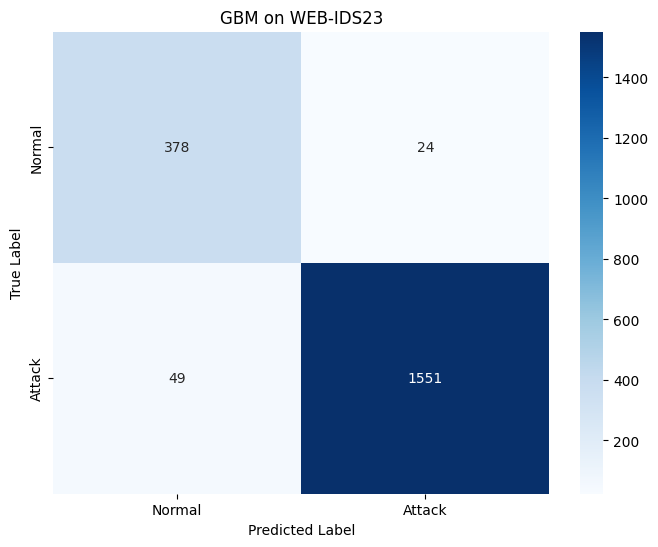

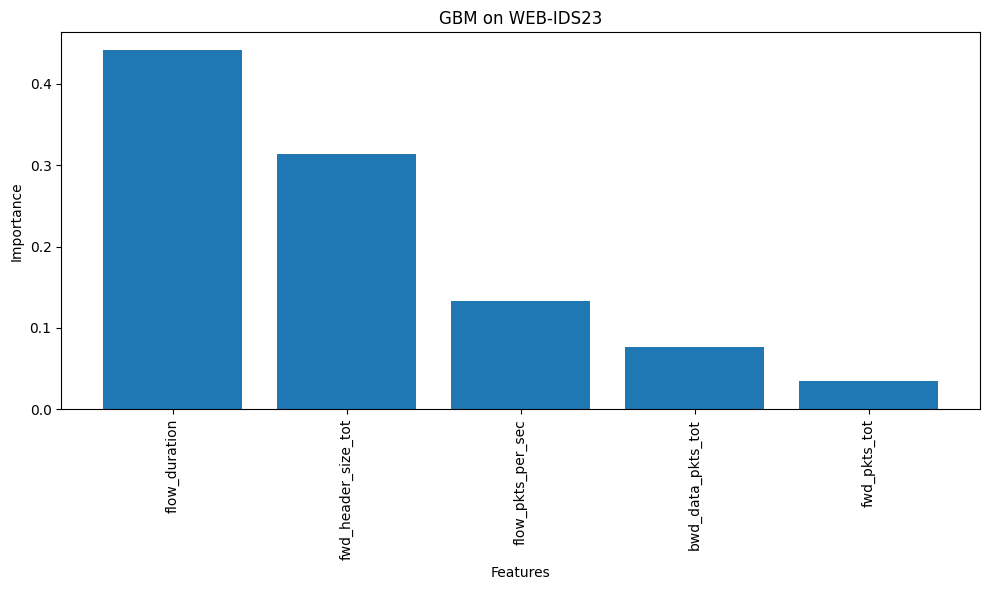

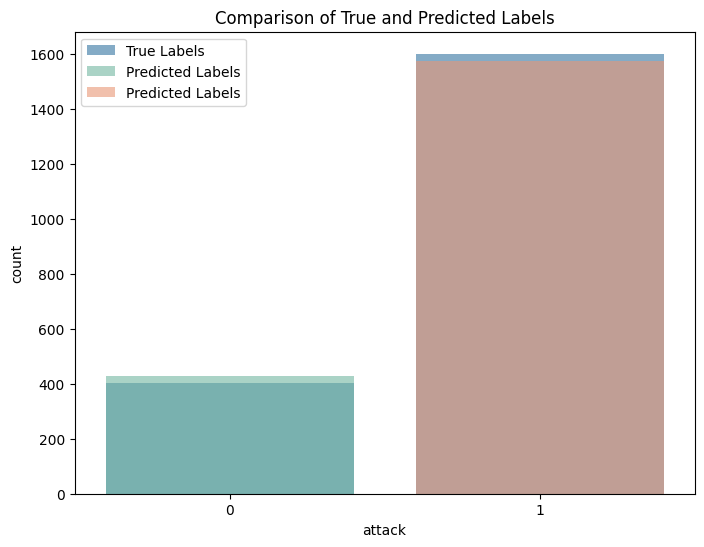

In [24]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("GBM on WEB-IDS23")
plt.show()

feature_importances = optimized_gbm_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.title("GBM on WEB-IDS23")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x=y_test, label="True Labels", alpha=0.6)
sns.countplot(x=y_pred, label="Predicted Labels", alpha=0.6, palette="Set2")
plt.legend()
plt.title("Comparison of True and Predicted Labels")
plt.show()

In [25]:
dump(optimized_gbm_model, "models\\gbm_model.joblib", compress=("xz", 3))

['models\\gbm_model.joblib']

In [26]:
del optimized_gbm_model
del gbm
del optimized_rf_model

### LightGBM

In [27]:
#lightGBM
param_grid = {
    'num_leaves': [31, 50],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200]
}

model = lgb.LGBMClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

optimized_lgb_model = grid_search.best_estimator_
y_pred = optimized_lgb_model.predict(X_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[LightGBM] [Info] Number of positive: 6400, number of negative: 1605
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 8005, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174


In [28]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

Accuracy: 0.9582555970149254
Confusion Matrix: [[ 381   21]
 [  50 1550]]


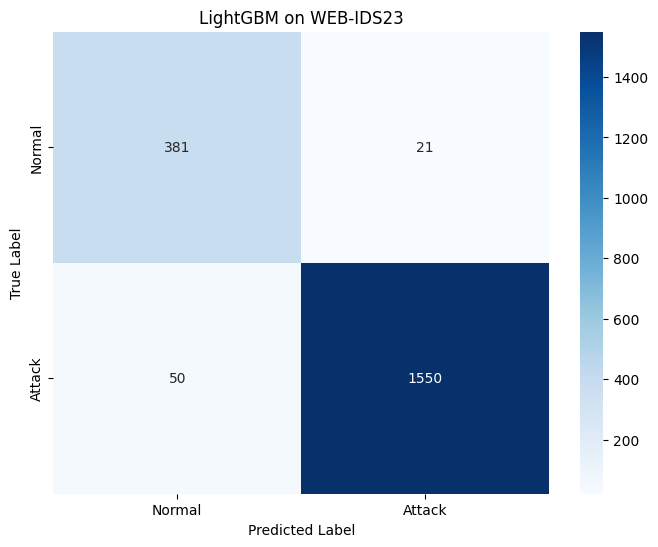

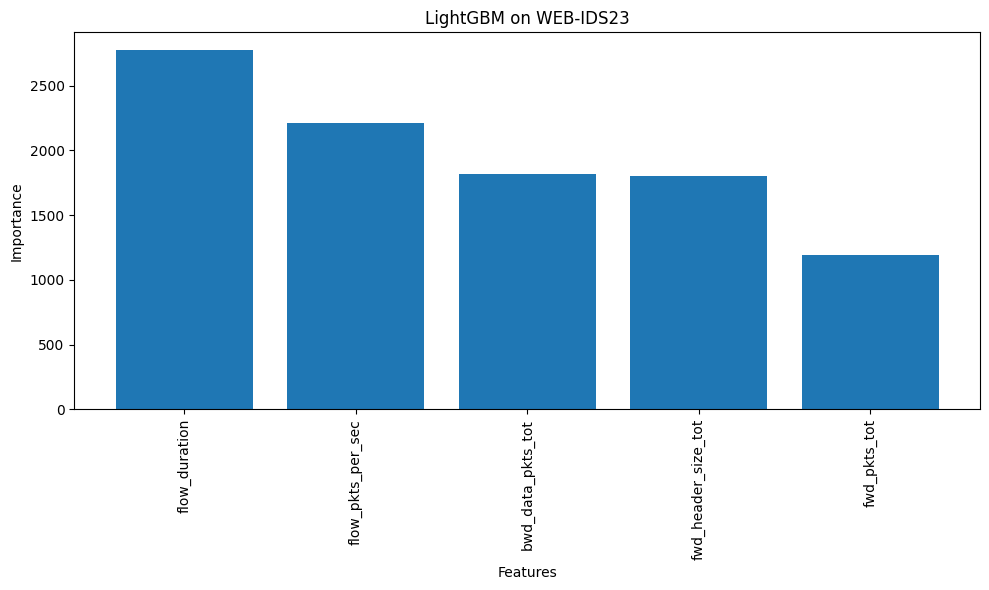

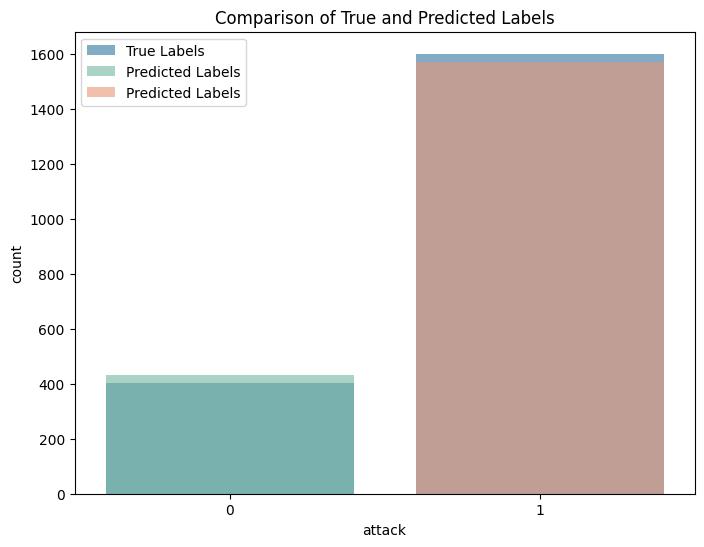

In [29]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("LightGBM on WEB-IDS23")
plt.show()

feature_importances = optimized_lgb_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.title("LightGBM on WEB-IDS23")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x=y_test, label="True Labels", alpha=0.6)
sns.countplot(x=y_pred, label="Predicted Labels", alpha=0.6, palette="Set2")
plt.legend()
plt.title("Comparison of True and Predicted Labels")
plt.show()

In [30]:
optimized_lgb_model.booster_.save_model('models\\lgb_model_gcv.txt')

In [31]:
def objective(trial):
    params = {
        'random_state': 42,
        'num_leaves': trial.suggest_categorical('num_leaves', [31, 50, 70, 100]),
        'max_depth': trial.suggest_categorical('max_depth', [-1, 10, 20, 30]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1]),
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 500]),
        'min_child_samples': trial.suggest_categorical('min_child_samples', [10, 20, 30]),
        'subsample': trial.suggest_categorical('subsample', [0.6, 0.8, 1.0]),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.6, 0.8, 1.0]),
        'reg_alpha': trial.suggest_categorical('reg_alpha', [0.0, 0.1, 0.5]),
        'reg_lambda': trial.suggest_categorical('reg_lambda', [0.0, 0.1, 0.5])
    }

    model = lgb.LGBMClassifier(**params)
    
    # Keresztvalidálás (5-fold Stratified)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, valid_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        f1 = f1_score(y_val, preds)
        f1_scores.append(f1)

    return sum(f1_scores) / len(f1_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

best_params = study.best_params
best_params['random_state'] = 42
optimized_lgb_model = lgb.LGBMClassifier(**best_params)
optimized_lgb_model.fit(X_train, y_train)

y_pred = optimized_lgb_model.predict(X_test)

[I 2025-04-23 01:00:52,508] A new study created in memory with name: no-name-c8c8c107-566f-4262-86eb-f08e572e3287
  0%|                                                                                                                                                                     | 0/50 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

Best trial: 0. Best value: 0.979264:   2%|██▍                                                                                                                     | 1/50 [00:00<00:32,  1.53it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 0. Best value: 0.979264:   4%|████▊                                                                                                                   | 2/50 [00:02<00:52,  1.10s/it]

[I 2025-04-23 01:00:54,575] Trial 1 finished with value: 0.9787355236310553 and parameters: {'num_leaves': 70, 'max_depth': -1, 'learning_rate': 0.05, 'n_estimators': 200, 'min_child_samples': 20, 'subsample': 0.8, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'reg_lambda': 0.0}. Best is trial 0 with value: 0.9792638407487688.
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

Best trial: 2. Best value: 0.979328:   6%|███████▏                                                                                                                | 3/50 [00:02<00:36,  1.28it/s]

[I 2025-04-23 01:00:54,969] Trial 2 finished with value: 0.9793281287342206 and parameters: {'num_leaves': 50, 'max_depth': 10, 'learning_rate': 0.1, 'n_estimators': 100, 'min_child_samples': 30, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.0, 'reg_lambda': 0.5}. Best is trial 2 with value: 0.9793281287342206.
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

Best trial: 2. Best value: 0.979328:   8%|█████████▌                                                                                                              | 4/50 [00:03<00:31,  1.45it/s]

[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1015
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

Best trial: 2. Best value: 0.979328:  10%|████████████                                                                                                            | 5/50 [00:04<00:39,  1.14it/s]

[I 2025-04-23 01:00:56,730] Trial 4 finished with value: 0.9792046000426712 and parameters: {'num_leaves': 70, 'max_depth': -1, 'learning_rate': 0.1, 'n_estimators': 200, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.6, 'reg_alpha': 0.5, 'reg_lambda': 0.1}. Best is trial 2 with value: 0.9793281287342206.
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

Best trial: 2. Best value: 0.979328:  12%|██████████████▍                                                                                                         | 6/50 [00:06<01:05,  1.48s/it]

[I 2025-04-23 01:00:59,397] Trial 5 finished with value: 0.9791815096592213 and parameters: {'num_leaves': 100, 'max_depth': 20, 'learning_rate': 0.05, 'n_estimators': 500, 'min_child_samples': 30, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 2 with value: 0.9793281287342206.
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

Best trial: 2. Best value: 0.979328:  14%|████████████████▊                                                                                                       | 7/50 [00:08<00:59,  1.39s/it]

[I 2025-04-23 01:01:00,586] Trial 6 finished with value: 0.9782384806278447 and parameters: {'num_leaves': 70, 'max_depth': 30, 'learning_rate': 0.1, 'n_estimators': 200, 'min_child_samples': 30, 'subsample': 0.8, 'colsample_bytree': 0.6, 'reg_alpha': 0.0, 'reg_lambda': 0.1}. Best is trial 2 with value: 0.9793281287342206.
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

Best trial: 7. Best value: 0.979347:  16%|███████████████████▏                                                                                                    | 8/50 [00:10<01:10,  1.67s/it]

[I 2025-04-23 01:01:02,868] Trial 7 finished with value: 0.9793470519796921 and parameters: {'num_leaves': 50, 'max_depth': 20, 'learning_rate': 0.05, 'n_estimators': 500, 'min_child_samples': 10, 'subsample': 0.8, 'colsample_bytree': 0.6, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 7 with value: 0.9793470519796921.
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

Best trial: 7. Best value: 0.979347:  18%|█████████████████████▌                                                                                                  | 9/50 [00:10<00:54,  1.34s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 7. Best value: 0.979347:  18%|█████████████████████▌                                                                                                  | 9/50 [00:11<00:54,  1.34s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] T

Best trial: 9. Best value: 0.979442:  20%|███████████████████████▊                                                                                               | 10/50 [00:11<00:41,  1.05s/it]

[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Info] Number

Best trial: 9. Best value: 0.979442:  22%|██████████████████████████▏                                                                                            | 11/50 [00:11<00:33,  1.18it/s]

[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1015
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[I 2025-04-23 01:01:04,2

Best trial: 9. Best value: 0.979442:  24%|████████████████████████████▌                                                                                          | 12/50 [00:13<00:41,  1.09s/it]

[I 2025-04-23 01:01:05,907] Trial 11 finished with value: 0.9791857858427349 and parameters: {'num_leaves': 31, 'max_depth': 20, 'learning_rate': 0.05, 'n_estimators': 500, 'min_child_samples': 20, 'subsample': 0.8, 'colsample_bytree': 0.6, 'reg_alpha': 0.1, 'reg_lambda': 0.0}. Best is trial 9 with value: 0.9794423343778119.
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 12. Best value: 0.979961:  26%|██████████████████████████████▋                                                                                       | 13/50 [00:15<00:51,  1.39s/it]

[I 2025-04-23 01:01:07,994] Trial 12 finished with value: 0.9799608602054464 and parameters: {'num_leaves': 50, 'max_depth': 10, 'learning_rate': 0.05, 'n_estimators': 500, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.6, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 12 with value: 0.9799608602054464.
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

Best trial: 12. Best value: 0.979961:  28%|█████████████████████████████████                                                                                     | 14/50 [00:17<00:52,  1.45s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 12. Best value: 0.979961:  30%|███████████████████████████████████▍                                                                                  | 15/50 [00:19<00:58,  1.67s/it]

[I 2025-04-23 01:01:11,744] Trial 14 finished with value: 0.9791279454873031 and parameters: {'num_leaves': 50, 'max_depth': 10, 'learning_rate': 0.01, 'n_estimators': 500, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.6, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 12 with value: 0.9799608602054464.
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

Best trial: 12. Best value: 0.979961:  32%|█████████████████████████████████████▊                                                                                | 16/50 [00:19<00:43,  1.27s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

Best trial: 12. Best value: 0.979961:  34%|████████████████████████████████████████                                                                              | 17/50 [00:21<00:50,  1.52s/it]

[I 2025-04-23 01:01:14,202] Trial 16 finished with value: 0.9794857938351458 and parameters: {'num_leaves': 50, 'max_depth': 10, 'learning_rate': 0.05, 'n_estimators': 500, 'min_child_samples': 20, 'subsample': 0.6, 'colsample_bytree': 0.6, 'reg_alpha': 0.5, 'reg_lambda': 0.0}. Best is trial 12 with value: 0.9799608602054464.
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

Best trial: 12. Best value: 0.979961:  36%|██████████████████████████████████████████▍                                                                           | 18/50 [00:23<00:53,  1.69s/it]

[I 2025-04-23 01:01:16,274] Trial 17 finished with value: 0.9794857938351458 and parameters: {'num_leaves': 50, 'max_depth': 10, 'learning_rate': 0.05, 'n_estimators': 500, 'min_child_samples': 20, 'subsample': 0.6, 'colsample_bytree': 0.6, 'reg_alpha': 0.5, 'reg_lambda': 0.0}. Best is trial 12 with value: 0.9799608602054464.
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

Best trial: 12. Best value: 0.979961:  38%|████████████████████████████████████████████▊                                                                         | 19/50 [00:26<00:59,  1.91s/it]

[I 2025-04-23 01:01:18,695] Trial 18 finished with value: 0.9797370733060285 and parameters: {'num_leaves': 50, 'max_depth': -1, 'learning_rate': 0.05, 'n_estimators': 500, 'min_child_samples': 10, 'subsample': 0.6, 'colsample_bytree': 0.8, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 12 with value: 0.9799608602054464.
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

Best trial: 12. Best value: 0.979961:  40%|███████████████████████████████████████████████▏                                                                      | 20/50 [00:28<01:01,  2.04s/it]

[I 2025-04-23 01:01:21,034] Trial 19 finished with value: 0.9797370733060285 and parameters: {'num_leaves': 50, 'max_depth': -1, 'learning_rate': 0.05, 'n_estimators': 500, 'min_child_samples': 10, 'subsample': 0.6, 'colsample_bytree': 0.8, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 12 with value: 0.9799608602054464.
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

Best trial: 12. Best value: 0.979961:  42%|█████████████████████████████████████████████████▌                                                                    | 21/50 [00:30<01:02,  2.15s/it]

[I 2025-04-23 01:01:23,451] Trial 20 finished with value: 0.9797370733060285 and parameters: {'num_leaves': 50, 'max_depth': -1, 'learning_rate': 0.05, 'n_estimators': 500, 'min_child_samples': 10, 'subsample': 0.6, 'colsample_bytree': 0.8, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 12 with value: 0.9799608602054464.
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

Best trial: 12. Best value: 0.979961:  44%|███████████████████████████████████████████████████▉                                                                  | 22/50 [00:33<01:02,  2.24s/it]

[I 2025-04-23 01:01:25,886] Trial 21 finished with value: 0.9797370733060285 and parameters: {'num_leaves': 50, 'max_depth': -1, 'learning_rate': 0.05, 'n_estimators': 500, 'min_child_samples': 10, 'subsample': 0.6, 'colsample_bytree': 0.8, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 12 with value: 0.9799608602054464.
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

Best trial: 12. Best value: 0.979961:  46%|██████████████████████████████████████████████████████▎                                                               | 23/50 [00:35<01:01,  2.29s/it]

[I 2025-04-23 01:01:28,307] Trial 22 finished with value: 0.9797370733060285 and parameters: {'num_leaves': 50, 'max_depth': -1, 'learning_rate': 0.05, 'n_estimators': 500, 'min_child_samples': 10, 'subsample': 0.6, 'colsample_bytree': 0.8, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 12 with value: 0.9799608602054464.
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

Best trial: 12. Best value: 0.979961:  48%|████████████████████████████████████████████████████████▋                                                             | 24/50 [00:38<01:00,  2.33s/it]

[I 2025-04-23 01:01:30,724] Trial 23 finished with value: 0.9797370733060285 and parameters: {'num_leaves': 50, 'max_depth': -1, 'learning_rate': 0.05, 'n_estimators': 500, 'min_child_samples': 10, 'subsample': 0.6, 'colsample_bytree': 0.8, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 12 with value: 0.9799608602054464.
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

Best trial: 12. Best value: 0.979961:  50%|███████████████████████████████████████████████████████████                                                           | 25/50 [00:40<00:58,  2.35s/it]

[I 2025-04-23 01:01:33,106] Trial 24 finished with value: 0.9797370733060285 and parameters: {'num_leaves': 50, 'max_depth': -1, 'learning_rate': 0.05, 'n_estimators': 500, 'min_child_samples': 10, 'subsample': 0.6, 'colsample_bytree': 0.8, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 12 with value: 0.9799608602054464.
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

Best trial: 12. Best value: 0.979961:  52%|█████████████████████████████████████████████████████████████▎                                                        | 26/50 [00:43<01:01,  2.55s/it]

[I 2025-04-23 01:01:36,121] Trial 25 finished with value: 0.9795858547700093 and parameters: {'num_leaves': 100, 'max_depth': -1, 'learning_rate': 0.05, 'n_estimators': 500, 'min_child_samples': 10, 'subsample': 0.6, 'colsample_bytree': 0.8, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 12 with value: 0.9799608602054464.
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

Best trial: 12. Best value: 0.979961:  54%|███████████████████████████████████████████████████████████████▋                                                      | 27/50 [00:44<00:47,  2.05s/it]

[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1015
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

Best trial: 12. Best value: 0.979961:  56%|██████████████████████████████████████████████████████████████████                                                    | 28/50 [00:46<00:47,  2.17s/it]

[I 2025-04-23 01:01:39,475] Trial 27 finished with value: 0.9793389530701543 and parameters: {'num_leaves': 50, 'max_depth': -1, 'learning_rate': 0.05, 'n_estimators': 500, 'min_child_samples': 30, 'subsample': 0.6, 'colsample_bytree': 1.0, 'reg_alpha': 0.5, 'reg_lambda': 0.1}. Best is trial 12 with value: 0.9799608602054464.
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

Best trial: 12. Best value: 0.979961:  58%|████████████████████████████████████████████████████████████████████▍                                                 | 29/50 [00:49<00:46,  2.23s/it]

[I 2025-04-23 01:01:41,832] Trial 28 finished with value: 0.9797370733060285 and parameters: {'num_leaves': 50, 'max_depth': -1, 'learning_rate': 0.05, 'n_estimators': 500, 'min_child_samples': 10, 'subsample': 0.6, 'colsample_bytree': 0.8, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 12 with value: 0.9799608602054464.
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

Best trial: 12. Best value: 0.979961:  60%|██████████████████████████████████████████████████████████████████████▊                                               | 30/50 [00:51<00:45,  2.27s/it]

[I 2025-04-23 01:01:44,190] Trial 29 finished with value: 0.9798079354560588 and parameters: {'num_leaves': 50, 'max_depth': 30, 'learning_rate': 0.05, 'n_estimators': 500, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.8, 'reg_alpha': 0.5, 'reg_lambda': 0.1}. Best is trial 12 with value: 0.9799608602054464.
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

Best trial: 12. Best value: 0.979961:  62%|█████████████████████████████████████████████████████████████████████████▏                                            | 31/50 [00:53<00:38,  2.05s/it]

[I 2025-04-23 01:01:45,728] Trial 30 finished with value: 0.9770344465175897 and parameters: {'num_leaves': 100, 'max_depth': 30, 'learning_rate': 0.01, 'n_estimators': 200, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.0, 'reg_lambda': 0.1}. Best is trial 12 with value: 0.9799608602054464.
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

Best trial: 12. Best value: 0.979961:  64%|███████████████████████████████████████████████████████████████████████████▌                                          | 32/50 [00:55<00:38,  2.13s/it]

[I 2025-04-23 01:01:48,053] Trial 31 finished with value: 0.9798079354560588 and parameters: {'num_leaves': 50, 'max_depth': 30, 'learning_rate': 0.05, 'n_estimators': 500, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.8, 'reg_alpha': 0.5, 'reg_lambda': 0.1}. Best is trial 12 with value: 0.9799608602054464.
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

Best trial: 12. Best value: 0.979961:  66%|█████████████████████████████████████████████████████████████████████████████▉                                        | 33/50 [00:57<00:37,  2.22s/it]

[I 2025-04-23 01:01:50,469] Trial 32 finished with value: 0.9798079354560588 and parameters: {'num_leaves': 50, 'max_depth': 30, 'learning_rate': 0.05, 'n_estimators': 500, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.8, 'reg_alpha': 0.5, 'reg_lambda': 0.1}. Best is trial 12 with value: 0.9799608602054464.
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

Best trial: 12. Best value: 0.979961:  68%|████████████████████████████████████████████████████████████████████████████████▏                                     | 34/50 [01:00<00:35,  2.25s/it]

[I 2025-04-23 01:01:52,781] Trial 33 finished with value: 0.9798079354560588 and parameters: {'num_leaves': 50, 'max_depth': 30, 'learning_rate': 0.05, 'n_estimators': 500, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.8, 'reg_alpha': 0.5, 'reg_lambda': 0.1}. Best is trial 12 with value: 0.9799608602054464.
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

Best trial: 12. Best value: 0.979961:  70%|██████████████████████████████████████████████████████████████████████████████████▌                                   | 35/50 [01:02<00:34,  2.28s/it]

[I 2025-04-23 01:01:55,146] Trial 34 finished with value: 0.9798079354560588 and parameters: {'num_leaves': 50, 'max_depth': 30, 'learning_rate': 0.05, 'n_estimators': 500, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.8, 'reg_alpha': 0.5, 'reg_lambda': 0.1}. Best is trial 12 with value: 0.9799608602054464.
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

Best trial: 12. Best value: 0.979961:  72%|████████████████████████████████████████████████████████████████████████████████████▉                                 | 36/50 [01:05<00:32,  2.32s/it]

[I 2025-04-23 01:01:57,550] Trial 35 finished with value: 0.9795000364538435 and parameters: {'num_leaves': 50, 'max_depth': 30, 'learning_rate': 0.05, 'n_estimators': 500, 'min_child_samples': 30, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.5, 'reg_lambda': 0.1}. Best is trial 12 with value: 0.9799608602054464.
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

Best trial: 12. Best value: 0.979961:  74%|███████████████████████████████████████████████████████████████████████████████████████▎                              | 37/50 [01:06<00:26,  2.07s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2025-04-23 01:01:59,037] Trial 36 finished with value: 0.978970257167074 and parameters: {'num_leaves': 100, 'max_depth': 30, 'learning_rate': 0.05, 'n_estimators': 200, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.8, 'reg_alpha': 0.0, 'reg_lambda': 0.1}. Best is trial 12 with value: 0.9799608602054464.
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

Best trial: 12. Best value: 0.979961:  76%|█████████████████████████████████████████████████████████████████████████████████████████▋                            | 38/50 [01:09<00:26,  2.22s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 12. Best value: 0.979961:  78%|████████████████████████████████████████████████████████████████████████████████████████████                          | 39/50 [01:11<00:25,  2.28s/it]

[I 2025-04-23 01:02:04,042] Trial 38 finished with value: 0.9795716536016581 and parameters: {'num_leaves': 50, 'max_depth': 30, 'learning_rate': 0.05, 'n_estimators': 500, 'min_child_samples': 30, 'subsample': 1.0, 'colsample_bytree': 0.8, 'reg_alpha': 0.5, 'reg_lambda': 0.1}. Best is trial 12 with value: 0.9799608602054464.
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set

[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1015
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[I 2025-04-23 01:02:05,008] Trial 39 finished with value: 0.9790474230371657 and parameters: {'num_leaves': 50, 'max_depth': 30, 'learning_rate': 0.1, 'n_estimators': 200, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.6, 'reg_alpha': 0.0, 'reg_lambda': 0.1}. Best is trial 12 with value: 0.9799608602054464.


Best trial: 12. Best value: 0.979961:  80%|██████████████████████████████████████████████████████████████████████████████████████████████▍                       | 40/50 [01:12<00:18,  1.89s/it]

[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

Best trial: 12. Best value: 0.979961:  82%|████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 41/50 [01:13<00:13,  1.49s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 12. Best value: 0.979961:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████                   | 42/50 [01:15<00:13,  1.74s/it]

[I 2025-04-23 01:02:07,906] Trial 41 finished with value: 0.9798079354560588 and parameters: {'num_leaves': 50, 'max_depth': 30, 'learning_rate': 0.05, 'n_estimators': 500, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.8, 'reg_alpha': 0.5, 'reg_lambda': 0.1}. Best is trial 12 with value: 0.9799608602054464.
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

Best trial: 12. Best value: 0.979961:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 43/50 [01:17<00:13,  1.92s/it]

[I 2025-04-23 01:02:10,225] Trial 42 finished with value: 0.9798079354560588 and parameters: {'num_leaves': 50, 'max_depth': 30, 'learning_rate': 0.05, 'n_estimators': 500, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.8, 'reg_alpha': 0.5, 'reg_lambda': 0.1}. Best is trial 12 with value: 0.9799608602054464.
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

Best trial: 12. Best value: 0.979961:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 44/50 [01:20<00:12,  2.03s/it]

[I 2025-04-23 01:02:12,505] Trial 43 finished with value: 0.9798079354560588 and parameters: {'num_leaves': 50, 'max_depth': 30, 'learning_rate': 0.05, 'n_estimators': 500, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.8, 'reg_alpha': 0.5, 'reg_lambda': 0.1}. Best is trial 12 with value: 0.9799608602054464.
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

Best trial: 12. Best value: 0.979961:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 45/50 [01:22<00:10,  2.13s/it]

[I 2025-04-23 01:02:14,877] Trial 44 finished with value: 0.9798079354560588 and parameters: {'num_leaves': 50, 'max_depth': 30, 'learning_rate': 0.05, 'n_estimators': 500, 'min_child_samples': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.5, 'reg_lambda': 0.1}. Best is trial 12 with value: 0.9799608602054464.
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

Best trial: 12. Best value: 0.979961:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 46/50 [01:25<00:09,  2.34s/it]

[I 2025-04-23 01:02:17,723] Trial 45 finished with value: 0.9791859129747478 and parameters: {'num_leaves': 100, 'max_depth': 20, 'learning_rate': 0.05, 'n_estimators': 500, 'min_child_samples': 30, 'subsample': 1.0, 'colsample_bytree': 0.6, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 12 with value: 0.9799608602054464.
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can se

Best trial: 46. Best value: 0.980292:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 47/50 [01:25<00:05,  1.79s/it]

[I 2025-04-23 01:02:18,225] Trial 46 finished with value: 0.980291847589345 and parameters: {'num_leaves': 50, 'max_depth': 30, 'learning_rate': 0.1, 'n_estimators': 100, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.8, 'reg_alpha': 0.5, 'reg_lambda': 0.1}. Best is trial 46 with value: 0.980291847589345.
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `f

Best trial: 46. Best value: 0.980292:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 48/50 [01:26<00:02,  1.43s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1015
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2025-04-23 01:02:18,796] Trial 47 finished with value: 0.9791181241572282 and parameters: {'num_leaves': 70, 'max_depth': 30, 'learning_rate': 0.1, 'n_estimators': 100, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.6, 'reg_alpha': 0.0, 'reg_lambda': 0.1}. Best is trial 46 with value: 0.980291847589345.
[LightGBM] [Info] Number of positive

Best trial: 46. Best value: 0.980292:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 49/50 [01:26<00:01,  1.11s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 46. Best value: 0.980292: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:27<00:00,  1.74s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5120, number of negative: 1284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1015
[LightGBM] [Info] Number of data points in the train set: 6404, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799500 -> initscore=1.383174
[LightGBM] [Info] Start training from score 1.383174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [32]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

Accuracy: 0.9604430970149254
Confusion Matrix: [[ 381   21]
 [  43 1557]]


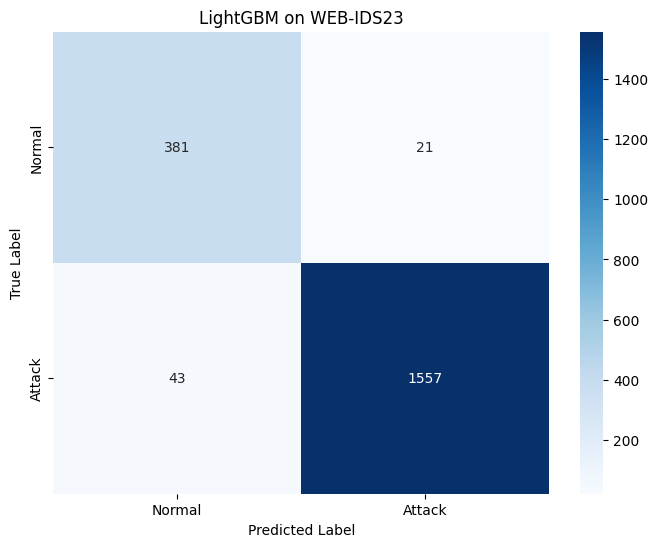

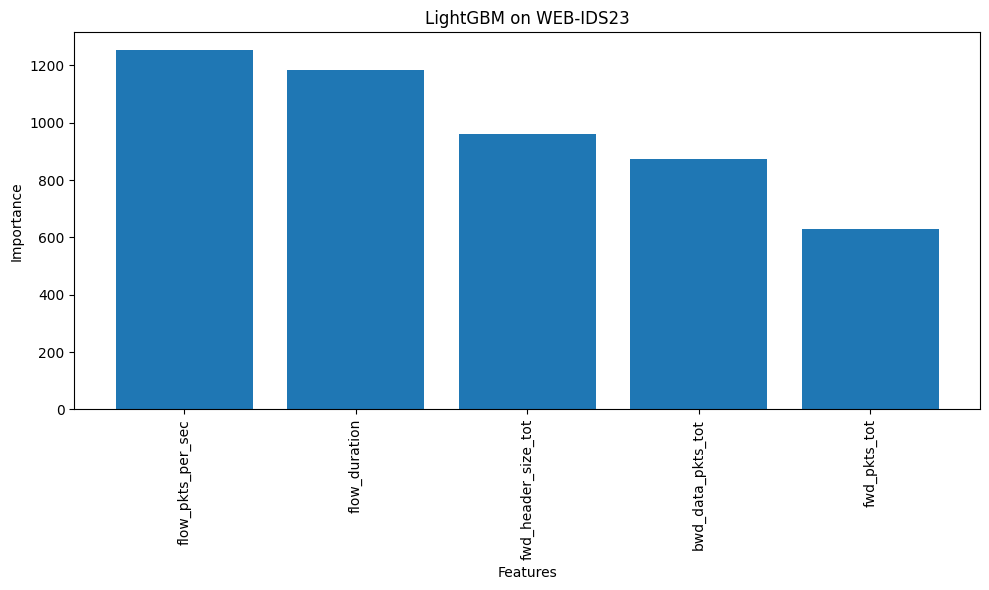

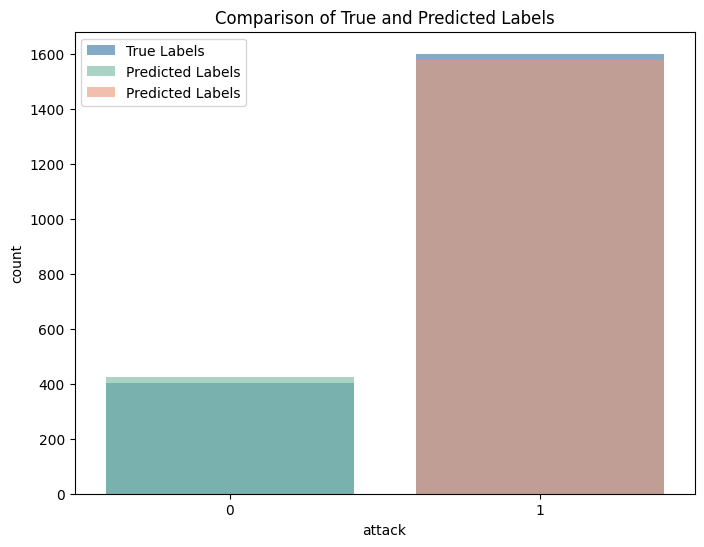

In [33]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("LightGBM on WEB-IDS23")
plt.show()

feature_importances = optimized_lgb_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.title("LightGBM on WEB-IDS23")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x=y_test, label="True Labels", alpha=0.6)
sns.countplot(x=y_pred, label="Predicted Labels", alpha=0.6, palette="Set2")
plt.legend()
plt.title("Comparison of True and Predicted Labels")
plt.show()

In [34]:
optimized_lgb_model.booster_.save_model('models\\lgb_model_optuna.txt')

In [35]:
del optimized_lgb_model

### CatBoost

In [36]:
param_grid = {
    'iterations': [100, 200],
    'learning_rate': [0.05, 0.1],
    'depth': [4, 6, 8]
}

model = CatBoostClassifier(verbose=0, random_state=42)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

optimized_catboost_model = grid_search.best_estimator_
y_pred = optimized_catboost_model.predict(X_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [37]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

Accuracy: 0.9610680970149253
Confusion Matrix: [[ 381   21]
 [  41 1559]]


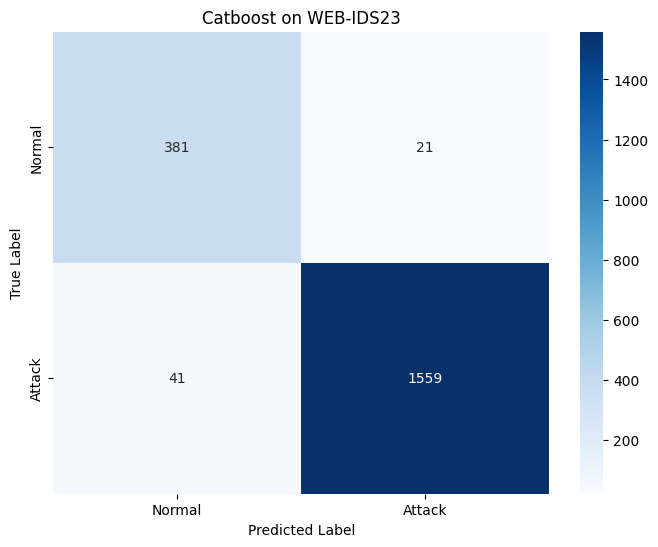

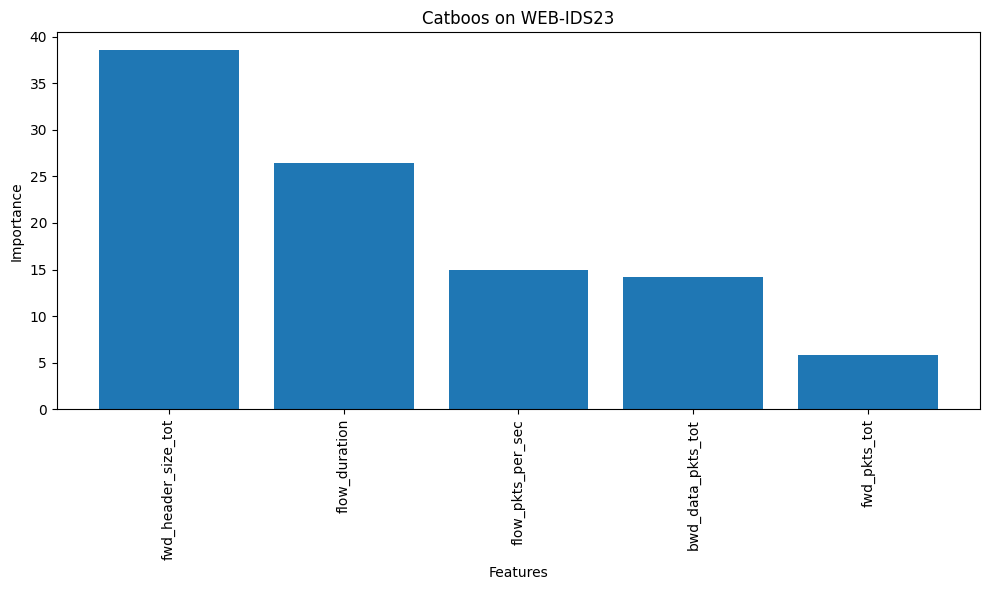

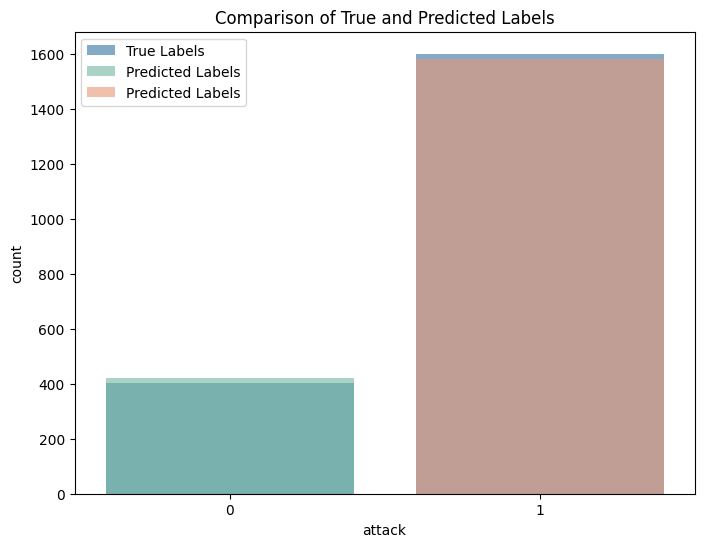

In [38]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Catboost on WEB-IDS23")
plt.show()

feature_importances = optimized_catboost_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.title("Catboos on WEB-IDS23")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x=y_test, label="True Labels", alpha=0.6)
sns.countplot(x=y_pred, label="Predicted Labels", alpha=0.6, palette="Set2")
plt.legend()
plt.title("Comparison of True and Predicted Labels")
plt.show()

In [39]:
optimized_catboost_model.save_model("models\\catboost_model_gcv.cbm")

In [40]:
def objective(trial):
    params = {
        'iterations': trial.suggest_categorical('iterations', [100, 200, 500, 1000]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.03, 0.05, 0.1]),
        'depth': trial.suggest_categorical('depth', [4, 6, 8, 10]),
        'l2_leaf_reg': trial.suggest_categorical('l2_leaf_reg', [1, 3, 5, 7, 10]),
        'border_count': trial.suggest_categorical('border_count', [32, 64, 128]),
        'bagging_temperature': trial.suggest_categorical('bagging_temperature', [0, 0.5, 1.0]),
        'random_strength': trial.suggest_categorical('random_strength', [0.5, 1, 2]),
        'rsm': trial.suggest_categorical('rsm', [0.8, 1.0]),
        'boosting_type': trial.suggest_categorical('boosting_type', ['Plain', 'Ordered']),
        'random_state': 42,
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    f1_scores = []
    for train_idx, valid_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        f1 = f1_score(y_val, preds)
        f1_scores.append(f1)

    return sum(f1_scores) / len(f1_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

best_params = study.best_params
best_params['random_state'] = 42
best_params['verbose'] = 0
optimized_catboost_model = CatBoostClassifier(**best_params)
optimized_catboost_model.fit(X_train, y_train)

y_pred = optimized_catboost_model.predict(X_test)

[I 2025-04-23 01:02:39,381] A new study created in memory with name: no-name-83d72fcd-b6ca-4964-8090-11d1045fcc1b
Best trial: 0. Best value: 0.973812:   2%|██▍                                                                                                                     | 1/50 [00:18<14:54, 18.25s/it]

[I 2025-04-23 01:02:57,627] Trial 0 finished with value: 0.9738116830634678 and parameters: {'iterations': 500, 'learning_rate': 0.01, 'depth': 8, 'l2_leaf_reg': 5, 'border_count': 128, 'bagging_temperature': 0, 'random_strength': 2, 'rsm': 0.8, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.9738116830634678.


Best trial: 0. Best value: 0.973812:   4%|████▊                                                                                                                   | 2/50 [00:20<07:04,  8.84s/it]

[I 2025-04-23 01:02:59,874] Trial 1 finished with value: 0.9711657630715103 and parameters: {'iterations': 100, 'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 5, 'border_count': 32, 'bagging_temperature': 0.5, 'random_strength': 0.5, 'rsm': 0.8, 'boosting_type': 'Ordered'}. Best is trial 0 with value: 0.9738116830634678.


Best trial: 2. Best value: 0.976324:   6%|███████▏                                                                                                                | 3/50 [01:06<20:06, 25.68s/it]

[I 2025-04-23 01:03:45,593] Trial 2 finished with value: 0.9763241072650743 and parameters: {'iterations': 500, 'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 3, 'border_count': 32, 'bagging_temperature': 0, 'random_strength': 2, 'rsm': 0.8, 'boosting_type': 'Ordered'}. Best is trial 2 with value: 0.9763241072650743.


Best trial: 2. Best value: 0.976324:   8%|█████████▌                                                                                                              | 4/50 [01:12<13:42, 17.87s/it]

[I 2025-04-23 01:03:51,497] Trial 3 finished with value: 0.9751748284489002 and parameters: {'iterations': 200, 'learning_rate': 0.03, 'depth': 8, 'l2_leaf_reg': 7, 'border_count': 64, 'bagging_temperature': 1.0, 'random_strength': 1, 'rsm': 1.0, 'boosting_type': 'Plain'}. Best is trial 2 with value: 0.9763241072650743.


Best trial: 2. Best value: 0.976324:  10%|████████████                                                                                                            | 5/50 [01:16<09:44, 12.99s/it]

[I 2025-04-23 01:03:55,825] Trial 4 finished with value: 0.9750275488264718 and parameters: {'iterations': 200, 'learning_rate': 0.05, 'depth': 4, 'l2_leaf_reg': 5, 'border_count': 32, 'bagging_temperature': 0.5, 'random_strength': 0.5, 'rsm': 1.0, 'boosting_type': 'Plain'}. Best is trial 2 with value: 0.9763241072650743.


Best trial: 2. Best value: 0.976324:  12%|██████████████▍                                                                                                         | 6/50 [01:18<06:43,  9.17s/it]

[I 2025-04-23 01:03:57,573] Trial 5 finished with value: 0.9712791358142152 and parameters: {'iterations': 100, 'learning_rate': 0.05, 'depth': 8, 'l2_leaf_reg': 10, 'border_count': 32, 'bagging_temperature': 0.5, 'random_strength': 0.5, 'rsm': 0.8, 'boosting_type': 'Plain'}. Best is trial 2 with value: 0.9763241072650743.


Best trial: 2. Best value: 0.976324:  14%|████████████████▊                                                                                                       | 7/50 [01:47<11:22, 15.87s/it]

[I 2025-04-23 01:04:27,247] Trial 6 finished with value: 0.9755526464803342 and parameters: {'iterations': 500, 'learning_rate': 0.05, 'depth': 4, 'l2_leaf_reg': 7, 'border_count': 64, 'bagging_temperature': 0, 'random_strength': 1, 'rsm': 1.0, 'boosting_type': 'Ordered'}. Best is trial 2 with value: 0.9763241072650743.


Best trial: 7. Best value: 0.976473:  16%|███████████████████▏                                                                                                    | 8/50 [02:23<15:30, 22.16s/it]

[I 2025-04-23 01:05:02,886] Trial 7 finished with value: 0.9764725322991042 and parameters: {'iterations': 1000, 'learning_rate': 0.03, 'depth': 10, 'l2_leaf_reg': 3, 'border_count': 32, 'bagging_temperature': 0, 'random_strength': 0.5, 'rsm': 0.8, 'boosting_type': 'Plain'}. Best is trial 7 with value: 0.9764725322991042.


Best trial: 7. Best value: 0.976473:  18%|█████████████████████▌                                                                                                  | 9/50 [02:28<11:32, 16.89s/it]

[I 2025-04-23 01:05:08,168] Trial 8 finished with value: 0.9755954045420798 and parameters: {'iterations': 200, 'learning_rate': 0.05, 'depth': 8, 'l2_leaf_reg': 10, 'border_count': 32, 'bagging_temperature': 0.5, 'random_strength': 2, 'rsm': 1.0, 'boosting_type': 'Plain'}. Best is trial 7 with value: 0.9764725322991042.


Best trial: 7. Best value: 0.976473:  20%|███████████████████████▊                                                                                               | 10/50 [03:32<20:49, 31.23s/it]

[I 2025-04-23 01:06:11,513] Trial 9 finished with value: 0.9760907084454183 and parameters: {'iterations': 1000, 'learning_rate': 0.01, 'depth': 10, 'l2_leaf_reg': 5, 'border_count': 128, 'bagging_temperature': 1.0, 'random_strength': 1, 'rsm': 0.8, 'boosting_type': 'Plain'}. Best is trial 7 with value: 0.9764725322991042.


Best trial: 10. Best value: 0.976704:  22%|█████████████████████████▉                                                                                            | 11/50 [05:03<32:13, 49.57s/it]

[I 2025-04-23 01:07:42,664] Trial 10 finished with value: 0.9767036628369843 and parameters: {'iterations': 1000, 'learning_rate': 0.03, 'depth': 6, 'l2_leaf_reg': 3, 'border_count': 64, 'bagging_temperature': 0, 'random_strength': 0.5, 'rsm': 0.8, 'boosting_type': 'Ordered'}. Best is trial 10 with value: 0.9767036628369843.


Best trial: 10. Best value: 0.976704:  24%|████████████████████████████▎                                                                                         | 12/50 [06:31<38:53, 61.42s/it]

[I 2025-04-23 01:09:11,180] Trial 11 finished with value: 0.9767036628369843 and parameters: {'iterations': 1000, 'learning_rate': 0.03, 'depth': 6, 'l2_leaf_reg': 3, 'border_count': 64, 'bagging_temperature': 0, 'random_strength': 0.5, 'rsm': 0.8, 'boosting_type': 'Ordered'}. Best is trial 10 with value: 0.9767036628369843.


Best trial: 10. Best value: 0.976704:  26%|██████████████████████████████▋                                                                                       | 13/50 [07:59<42:48, 69.42s/it]

[I 2025-04-23 01:10:39,020] Trial 12 finished with value: 0.9760138060694693 and parameters: {'iterations': 1000, 'learning_rate': 0.03, 'depth': 6, 'l2_leaf_reg': 1, 'border_count': 64, 'bagging_temperature': 0, 'random_strength': 0.5, 'rsm': 0.8, 'boosting_type': 'Ordered'}. Best is trial 10 with value: 0.9767036628369843.


Best trial: 10. Best value: 0.976704:  28%|█████████████████████████████████                                                                                     | 14/50 [09:28<45:14, 75.41s/it]

[I 2025-04-23 01:12:08,276] Trial 13 finished with value: 0.9767036628369843 and parameters: {'iterations': 1000, 'learning_rate': 0.03, 'depth': 6, 'l2_leaf_reg': 3, 'border_count': 64, 'bagging_temperature': 0, 'random_strength': 0.5, 'rsm': 0.8, 'boosting_type': 'Ordered'}. Best is trial 10 with value: 0.9767036628369843.


Best trial: 10. Best value: 0.976704:  30%|███████████████████████████████████▍                                                                                  | 15/50 [10:57<46:19, 79.42s/it]

[I 2025-04-23 01:13:36,981] Trial 14 finished with value: 0.9767036628369843 and parameters: {'iterations': 1000, 'learning_rate': 0.03, 'depth': 6, 'l2_leaf_reg': 3, 'border_count': 64, 'bagging_temperature': 0, 'random_strength': 0.5, 'rsm': 0.8, 'boosting_type': 'Ordered'}. Best is trial 10 with value: 0.9767036628369843.


Best trial: 10. Best value: 0.976704:  32%|█████████████████████████████████████▊                                                                                | 16/50 [12:26<46:42, 82.42s/it]

[I 2025-04-23 01:15:06,372] Trial 15 finished with value: 0.9767036628369843 and parameters: {'iterations': 1000, 'learning_rate': 0.03, 'depth': 6, 'l2_leaf_reg': 3, 'border_count': 64, 'bagging_temperature': 0, 'random_strength': 0.5, 'rsm': 0.8, 'boosting_type': 'Ordered'}. Best is trial 10 with value: 0.9767036628369843.


Best trial: 10. Best value: 0.976704:  34%|████████████████████████████████████████                                                                              | 17/50 [13:55<46:15, 84.11s/it]

[I 2025-04-23 01:16:34,421] Trial 16 finished with value: 0.9760138060694693 and parameters: {'iterations': 1000, 'learning_rate': 0.03, 'depth': 6, 'l2_leaf_reg': 1, 'border_count': 64, 'bagging_temperature': 1.0, 'random_strength': 0.5, 'rsm': 0.8, 'boosting_type': 'Ordered'}. Best is trial 10 with value: 0.9767036628369843.


Best trial: 10. Best value: 0.976704:  36%|██████████████████████████████████████████▍                                                                           | 18/50 [15:23<45:35, 85.47s/it]

[I 2025-04-23 01:18:03,055] Trial 17 finished with value: 0.9767036628369843 and parameters: {'iterations': 1000, 'learning_rate': 0.03, 'depth': 6, 'l2_leaf_reg': 3, 'border_count': 64, 'bagging_temperature': 0, 'random_strength': 0.5, 'rsm': 0.8, 'boosting_type': 'Ordered'}. Best is trial 10 with value: 0.9767036628369843.


Best trial: 10. Best value: 0.976704:  38%|████████████████████████████████████████████▊                                                                         | 19/50 [15:27<31:28, 60.90s/it]

[I 2025-04-23 01:18:06,732] Trial 18 finished with value: 0.9571952434656618 and parameters: {'iterations': 100, 'learning_rate': 0.01, 'depth': 6, 'l2_leaf_reg': 3, 'border_count': 128, 'bagging_temperature': 0, 'random_strength': 2, 'rsm': 1.0, 'boosting_type': 'Ordered'}. Best is trial 10 with value: 0.9767036628369843.


Best trial: 19. Best value: 0.977345:  40%|███████████████████████████████████████████████▏                                                                      | 20/50 [16:52<34:05, 68.20s/it]

[I 2025-04-23 01:19:31,933] Trial 19 finished with value: 0.9773451260097907 and parameters: {'iterations': 1000, 'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 3, 'border_count': 64, 'bagging_temperature': 1.0, 'random_strength': 1, 'rsm': 0.8, 'boosting_type': 'Ordered'}. Best is trial 19 with value: 0.9773451260097907.


Best trial: 19. Best value: 0.977345:  42%|█████████████████████████████████████████████████▌                                                                    | 21/50 [18:16<35:17, 73.03s/it]

[I 2025-04-23 01:20:56,220] Trial 20 finished with value: 0.9772769442938782 and parameters: {'iterations': 1000, 'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 7, 'border_count': 64, 'bagging_temperature': 1.0, 'random_strength': 1, 'rsm': 0.8, 'boosting_type': 'Ordered'}. Best is trial 19 with value: 0.9773451260097907.


Best trial: 19. Best value: 0.977345:  44%|███████████████████████████████████████████████████▉                                                                  | 22/50 [19:41<35:38, 76.38s/it]

[I 2025-04-23 01:22:20,409] Trial 21 finished with value: 0.9772769442938782 and parameters: {'iterations': 1000, 'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 7, 'border_count': 64, 'bagging_temperature': 1.0, 'random_strength': 1, 'rsm': 0.8, 'boosting_type': 'Ordered'}. Best is trial 19 with value: 0.9773451260097907.


Best trial: 19. Best value: 0.977345:  46%|██████████████████████████████████████████████████████▎                                                               | 23/50 [21:05<35:28, 78.82s/it]

[I 2025-04-23 01:23:44,911] Trial 22 finished with value: 0.9772769442938782 and parameters: {'iterations': 1000, 'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 7, 'border_count': 64, 'bagging_temperature': 1.0, 'random_strength': 1, 'rsm': 0.8, 'boosting_type': 'Ordered'}. Best is trial 19 with value: 0.9773451260097907.


Best trial: 19. Best value: 0.977345:  48%|████████████████████████████████████████████████████████▋                                                             | 24/50 [22:29<34:51, 80.44s/it]

[I 2025-04-23 01:25:09,142] Trial 23 finished with value: 0.9772769442938782 and parameters: {'iterations': 1000, 'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 7, 'border_count': 64, 'bagging_temperature': 1.0, 'random_strength': 1, 'rsm': 0.8, 'boosting_type': 'Ordered'}. Best is trial 19 with value: 0.9773451260097907.


Best trial: 19. Best value: 0.977345:  50%|███████████████████████████████████████████████████████████                                                           | 25/50 [23:53<33:56, 81.46s/it]

[I 2025-04-23 01:26:32,967] Trial 24 finished with value: 0.9772769442938782 and parameters: {'iterations': 1000, 'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 7, 'border_count': 64, 'bagging_temperature': 1.0, 'random_strength': 1, 'rsm': 0.8, 'boosting_type': 'Ordered'}. Best is trial 19 with value: 0.9773451260097907.


Best trial: 19. Best value: 0.977345:  52%|█████████████████████████████████████████████████████████████▎                                                        | 26/50 [25:25<33:48, 84.54s/it]

[I 2025-04-23 01:28:04,693] Trial 25 finished with value: 0.9764751560842942 and parameters: {'iterations': 1000, 'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 7, 'border_count': 128, 'bagging_temperature': 1.0, 'random_strength': 1, 'rsm': 0.8, 'boosting_type': 'Ordered'}. Best is trial 19 with value: 0.9773451260097907.


Best trial: 19. Best value: 0.977345:  54%|███████████████████████████████████████████████████████████████▋                                                      | 27/50 [26:06<27:22, 71.40s/it]

[I 2025-04-23 01:28:45,458] Trial 26 finished with value: 0.9767216293837933 and parameters: {'iterations': 500, 'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 7, 'border_count': 64, 'bagging_temperature': 1.0, 'random_strength': 1, 'rsm': 1.0, 'boosting_type': 'Ordered'}. Best is trial 19 with value: 0.9773451260097907.


Best trial: 27. Best value: 0.977567:  56%|██████████████████████████████████████████████████████████████████                                                    | 28/50 [26:42<22:20, 60.95s/it]

[I 2025-04-23 01:29:22,023] Trial 27 finished with value: 0.977566784434646 and parameters: {'iterations': 200, 'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 7, 'border_count': 64, 'bagging_temperature': 1.0, 'random_strength': 1, 'rsm': 0.8, 'boosting_type': 'Ordered'}. Best is trial 27 with value: 0.977566784434646.


Best trial: 27. Best value: 0.977567:  58%|████████████████████████████████████████████████████████████████████▍                                                 | 29/50 [27:15<18:20, 52.41s/it]

[I 2025-04-23 01:29:54,493] Trial 28 finished with value: 0.9767441238444906 and parameters: {'iterations': 200, 'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 1, 'border_count': 64, 'bagging_temperature': 1.0, 'random_strength': 1, 'rsm': 0.8, 'boosting_type': 'Ordered'}. Best is trial 27 with value: 0.977566784434646.


Best trial: 27. Best value: 0.977567:  60%|██████████████████████████████████████████████████████████████████████▊                                               | 30/50 [28:10<17:48, 53.42s/it]

[I 2025-04-23 01:30:50,276] Trial 29 finished with value: 0.9767878920301293 and parameters: {'iterations': 200, 'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 10, 'border_count': 128, 'bagging_temperature': 1.0, 'random_strength': 1, 'rsm': 0.8, 'boosting_type': 'Ordered'}. Best is trial 27 with value: 0.977566784434646.


Best trial: 27. Best value: 0.977567:  62%|█████████████████████████████████████████████████████████████████████████▏                                            | 31/50 [28:51<15:41, 49.54s/it]

[I 2025-04-23 01:31:30,756] Trial 30 finished with value: 0.9722036450635649 and parameters: {'iterations': 200, 'learning_rate': 0.01, 'depth': 10, 'l2_leaf_reg': 7, 'border_count': 64, 'bagging_temperature': 1.0, 'random_strength': 1, 'rsm': 0.8, 'boosting_type': 'Ordered'}. Best is trial 27 with value: 0.977566784434646.


Best trial: 27. Best value: 0.977567:  64%|███████████████████████████████████████████████████████████████████████████▌                                          | 32/50 [29:27<13:39, 45.55s/it]

[I 2025-04-23 01:32:06,992] Trial 31 finished with value: 0.977566784434646 and parameters: {'iterations': 200, 'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 7, 'border_count': 64, 'bagging_temperature': 1.0, 'random_strength': 1, 'rsm': 0.8, 'boosting_type': 'Ordered'}. Best is trial 27 with value: 0.977566784434646.


Best trial: 27. Best value: 0.977567:  66%|█████████████████████████████████████████████████████████████████████████████▉                                        | 33/50 [30:03<12:07, 42.78s/it]

[I 2025-04-23 01:32:43,319] Trial 32 finished with value: 0.977566784434646 and parameters: {'iterations': 200, 'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 7, 'border_count': 64, 'bagging_temperature': 1.0, 'random_strength': 1, 'rsm': 0.8, 'boosting_type': 'Ordered'}. Best is trial 27 with value: 0.977566784434646.


Best trial: 27. Best value: 0.977567:  68%|████████████████████████████████████████████████████████████████████████████████▏                                     | 34/50 [30:40<10:53, 40.82s/it]

[I 2025-04-23 01:33:19,570] Trial 33 finished with value: 0.977566784434646 and parameters: {'iterations': 200, 'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 7, 'border_count': 64, 'bagging_temperature': 1.0, 'random_strength': 1, 'rsm': 0.8, 'boosting_type': 'Ordered'}. Best is trial 27 with value: 0.977566784434646.


Best trial: 27. Best value: 0.977567:  70%|██████████████████████████████████████████████████████████████████████████████████▌                                   | 35/50 [31:16<09:52, 39.50s/it]

[I 2025-04-23 01:33:55,958] Trial 34 finished with value: 0.977566784434646 and parameters: {'iterations': 200, 'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 7, 'border_count': 64, 'bagging_temperature': 1.0, 'random_strength': 1, 'rsm': 0.8, 'boosting_type': 'Ordered'}. Best is trial 27 with value: 0.977566784434646.


Best trial: 27. Best value: 0.977567:  72%|████████████████████████████████████████████████████████████████████████████████████▉                                 | 36/50 [31:54<09:06, 39.01s/it]

[I 2025-04-23 01:34:33,857] Trial 35 finished with value: 0.9770979592390754 and parameters: {'iterations': 200, 'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 7, 'border_count': 64, 'bagging_temperature': 1.0, 'random_strength': 2, 'rsm': 0.8, 'boosting_type': 'Ordered'}. Best is trial 27 with value: 0.977566784434646.


Best trial: 27. Best value: 0.977567:  74%|███████████████████████████████████████████████████████████████████████████████████████▎                              | 37/50 [32:07<06:47, 31.31s/it]

[I 2025-04-23 01:34:47,194] Trial 36 finished with value: 0.977082836046215 and parameters: {'iterations': 200, 'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 7, 'border_count': 128, 'bagging_temperature': 0.5, 'random_strength': 1, 'rsm': 1.0, 'boosting_type': 'Plain'}. Best is trial 27 with value: 0.977566784434646.


Best trial: 27. Best value: 0.977567:  76%|█████████████████████████████████████████████████████████████████████████████████████████▋                            | 38/50 [32:33<05:56, 29.68s/it]

[I 2025-04-23 01:35:13,084] Trial 37 finished with value: 0.9765187318093937 and parameters: {'iterations': 200, 'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 5, 'border_count': 32, 'bagging_temperature': 1.0, 'random_strength': 1, 'rsm': 0.8, 'boosting_type': 'Ordered'}. Best is trial 27 with value: 0.977566784434646.


Best trial: 27. Best value: 0.977567:  78%|████████████████████████████████████████████████████████████████████████████████████████████                          | 39/50 [32:43<04:19, 23.57s/it]

[I 2025-04-23 01:35:22,402] Trial 38 finished with value: 0.9764941354733452 and parameters: {'iterations': 200, 'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 7, 'border_count': 64, 'bagging_temperature': 1.0, 'random_strength': 1, 'rsm': 0.8, 'boosting_type': 'Plain'}. Best is trial 27 with value: 0.977566784434646.


Best trial: 27. Best value: 0.977567:  80%|██████████████████████████████████████████████████████████████████████████████████████████████▍                       | 40/50 [32:58<03:31, 21.13s/it]

[I 2025-04-23 01:35:37,827] Trial 39 finished with value: 0.9731963400390834 and parameters: {'iterations': 200, 'learning_rate': 0.05, 'depth': 4, 'l2_leaf_reg': 7, 'border_count': 32, 'bagging_temperature': 0.5, 'random_strength': 2, 'rsm': 1.0, 'boosting_type': 'Ordered'}. Best is trial 27 with value: 0.977566784434646.


Best trial: 27. Best value: 0.977567:  82%|████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 41/50 [33:01<02:21, 15.78s/it]

[I 2025-04-23 01:35:41,122] Trial 40 finished with value: 0.973224639672283 and parameters: {'iterations': 100, 'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 10, 'border_count': 64, 'bagging_temperature': 1.0, 'random_strength': 1, 'rsm': 0.8, 'boosting_type': 'Plain'}. Best is trial 27 with value: 0.977566784434646.


Best trial: 27. Best value: 0.977567:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████                   | 42/50 [33:37<02:55, 21.90s/it]

[I 2025-04-23 01:36:17,279] Trial 41 finished with value: 0.977566784434646 and parameters: {'iterations': 200, 'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 7, 'border_count': 64, 'bagging_temperature': 1.0, 'random_strength': 1, 'rsm': 0.8, 'boosting_type': 'Ordered'}. Best is trial 27 with value: 0.977566784434646.


Best trial: 27. Best value: 0.977567:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 43/50 [34:14<03:03, 26.17s/it]

[I 2025-04-23 01:36:53,418] Trial 42 finished with value: 0.977566784434646 and parameters: {'iterations': 200, 'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 7, 'border_count': 64, 'bagging_temperature': 1.0, 'random_strength': 1, 'rsm': 0.8, 'boosting_type': 'Ordered'}. Best is trial 27 with value: 0.977566784434646.


Best trial: 27. Best value: 0.977567:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 44/50 [34:35<02:28, 24.75s/it]

[I 2025-04-23 01:37:14,875] Trial 43 finished with value: 0.9770157772421741 and parameters: {'iterations': 200, 'learning_rate': 0.1, 'depth': 8, 'l2_leaf_reg': 7, 'border_count': 64, 'bagging_temperature': 1.0, 'random_strength': 1, 'rsm': 0.8, 'boosting_type': 'Ordered'}. Best is trial 27 with value: 0.977566784434646.


Best trial: 27. Best value: 0.977567:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 45/50 [35:16<02:27, 29.49s/it]

[I 2025-04-23 01:37:55,419] Trial 44 finished with value: 0.9719625781811734 and parameters: {'iterations': 200, 'learning_rate': 0.01, 'depth': 10, 'l2_leaf_reg': 5, 'border_count': 64, 'bagging_temperature': 1.0, 'random_strength': 1, 'rsm': 0.8, 'boosting_type': 'Ordered'}. Best is trial 27 with value: 0.977566784434646.


Best trial: 27. Best value: 0.977567:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 46/50 [36:18<02:37, 39.41s/it]

[I 2025-04-23 01:38:57,963] Trial 45 finished with value: 0.9769881940262668 and parameters: {'iterations': 500, 'learning_rate': 0.05, 'depth': 10, 'l2_leaf_reg': 7, 'border_count': 32, 'bagging_temperature': 0.5, 'random_strength': 1, 'rsm': 0.8, 'boosting_type': 'Ordered'}. Best is trial 27 with value: 0.977566784434646.


Best trial: 27. Best value: 0.977567:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 47/50 [36:34<01:36, 32.27s/it]

[I 2025-04-23 01:39:13,574] Trial 46 finished with value: 0.9749378945022418 and parameters: {'iterations': 200, 'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 7, 'border_count': 64, 'bagging_temperature': 1.0, 'random_strength': 1, 'rsm': 0.8, 'boosting_type': 'Ordered'}. Best is trial 27 with value: 0.977566784434646.


Best trial: 27. Best value: 0.977567:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 48/50 [36:43<00:50, 25.45s/it]

[I 2025-04-23 01:39:23,133] Trial 47 finished with value: 0.9761782356159376 and parameters: {'iterations': 200, 'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 7, 'border_count': 64, 'bagging_temperature': 1.0, 'random_strength': 2, 'rsm': 1.0, 'boosting_type': 'Plain'}. Best is trial 27 with value: 0.977566784434646.


Best trial: 27. Best value: 0.977567:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 49/50 [37:18<00:28, 28.30s/it]

[I 2025-04-23 01:39:58,081] Trial 48 finished with value: 0.977566784434646 and parameters: {'iterations': 200, 'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 7, 'border_count': 64, 'bagging_temperature': 1.0, 'random_strength': 1, 'rsm': 0.8, 'boosting_type': 'Ordered'}. Best is trial 27 with value: 0.977566784434646.


Best trial: 27. Best value: 0.977567: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [37:38<00:00, 45.18s/it]


[I 2025-04-23 01:40:18,308] Trial 49 finished with value: 0.9764888013620958 and parameters: {'iterations': 200, 'learning_rate': 0.1, 'depth': 8, 'l2_leaf_reg': 1, 'border_count': 64, 'bagging_temperature': 0.5, 'random_strength': 1, 'rsm': 0.8, 'boosting_type': 'Ordered'}. Best is trial 27 with value: 0.977566784434646.


In [41]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

Accuracy: 0.9448989427860697
Confusion Matrix: [[ 368   34]
 [  41 1559]]


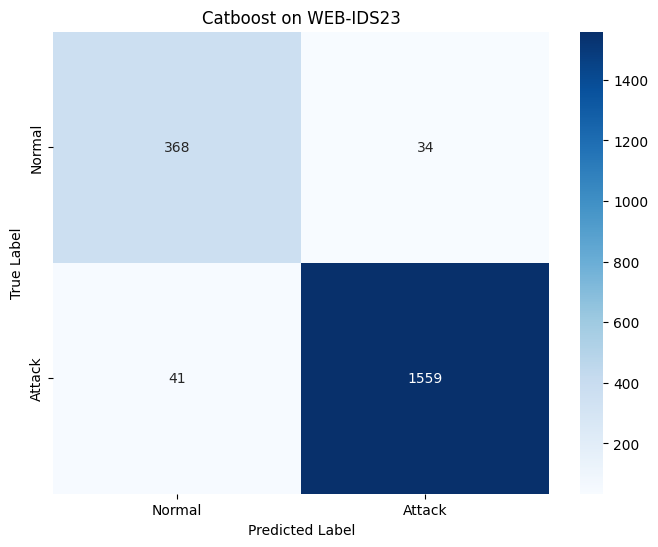

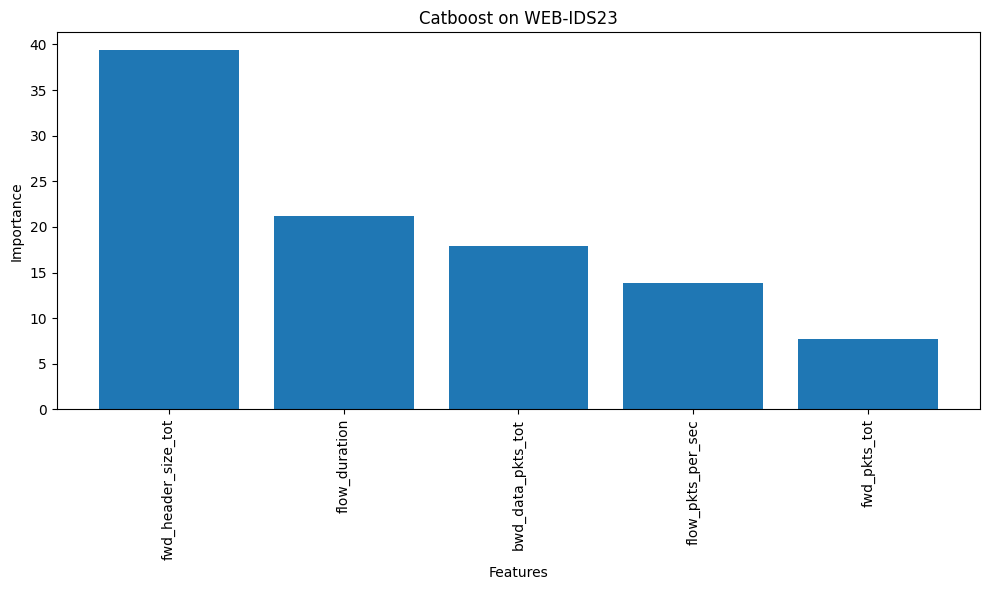

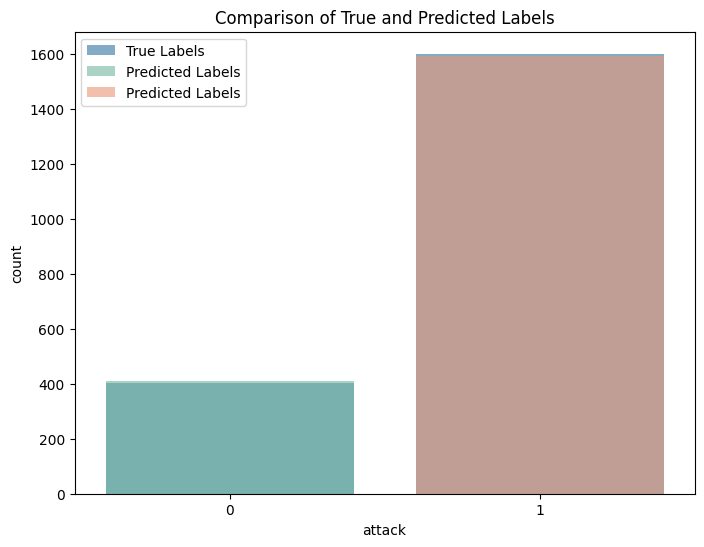

In [42]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Catboost on WEB-IDS23")
plt.show()

feature_importances = optimized_catboost_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.title("Catboost on WEB-IDS23")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x=y_test, label="True Labels", alpha=0.6)
sns.countplot(x=y_pred, label="Predicted Labels", alpha=0.6, palette="Set2")
plt.legend()
plt.title("Comparison of True and Predicted Labels")
plt.show()

In [43]:
optimized_catboost_model.save_model("models\\catboost_model_optuna.cbm")

In [44]:
del optimized_catboost_model

### XGBoost

In [45]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

model = xgb(use_label_encoder=False, eval_metric='logloss', random_state=42)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

optimized_xgboost_model = grid_search.best_estimator_
y_pred = optimized_xgboost_model.predict(X_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [46]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

Accuracy: 0.9576430348258707
Confusion Matrix: [[ 379   23]
 [  44 1556]]


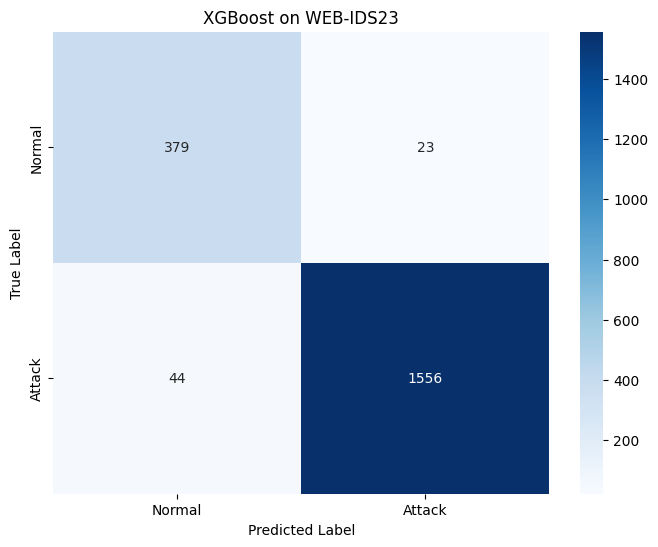

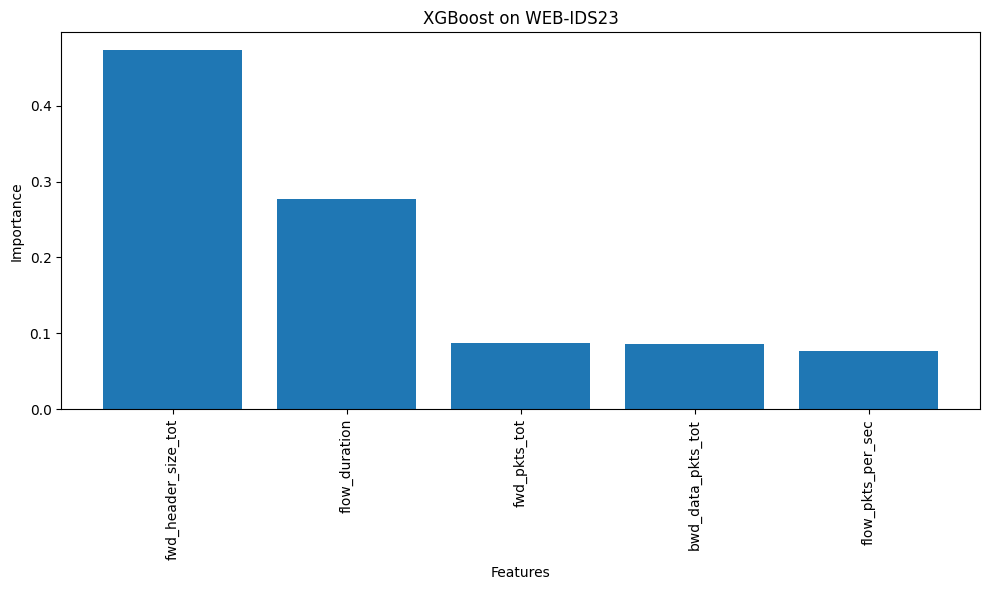

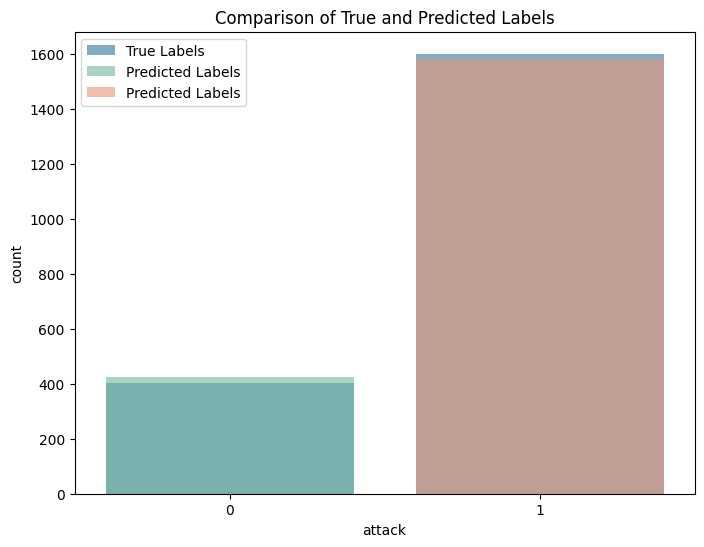

In [47]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("XGBoost on WEB-IDS23")
plt.show()

feature_importances = optimized_xgboost_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.title("XGBoost on WEB-IDS23")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x=y_test, label="True Labels", alpha=0.6)
sns.countplot(x=y_pred, label="Predicted Labels", alpha=0.6, palette="Set2")
plt.legend()
plt.title("Comparison of True and Predicted Labels")
plt.show()

In [48]:
optimized_xgboost_model.save_model("models\\xgboost_model_gcv.json")

In [49]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 500, 1000]),
        'max_depth': trial.suggest_categorical('max_depth', [3, 4, 6, 8, 10]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.03, 0.05, 0.1]),
        'subsample': trial.suggest_categorical('subsample', [0.6, 0.8, 1.0]),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.6, 0.8, 1.0]),
        'gamma': trial.suggest_categorical('gamma', [0, 0.1, 0.3, 0.5]),
        'reg_alpha': trial.suggest_categorical('reg_alpha', [0, 0.1, 0.5, 1.0]),
        'reg_lambda': trial.suggest_categorical('reg_lambda', [0.5, 1.0, 2.0]),
        'min_child_weight': trial.suggest_categorical('min_child_weight', [1, 3, 5, 10]),
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [1, 2, 5]),
        'tree_method': trial.suggest_categorical('tree_method', ['auto', 'hist']),
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'random_state': 42
    }

    model = xgb(**params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    f1_scores = []
    for train_idx, valid_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        f1 = f1_score(y_val, preds)
        f1_scores.append(f1)

    return sum(f1_scores) / len(f1_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

best_params = study.best_params
best_params.update({
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'random_state': 42
})
optimized_xgboost_model = xgb(**best_params)
optimized_xgboost_model.fit(X_train, y_train)

y_pred = optimized_xgboost_model.predict(X_test)

[I 2025-04-23 01:40:35,606] A new study created in memory with name: no-name-e1accba8-e2c1-4b1c-8ccd-b35a10d9b48f
Best trial: 0. Best value: 0.976255:   2%|██▍                                                                                                                     | 1/50 [00:01<00:58,  1.19s/it]

[I 2025-04-23 01:40:36,781] Trial 0 finished with value: 0.9762546418325571 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'min_child_weight': 1, 'scale_pos_weight': 2, 'tree_method': 'hist'}. Best is trial 0 with value: 0.9762546418325571.


Best trial: 0. Best value: 0.976255:   4%|████▊                                                                                                                   | 2/50 [00:03<01:20,  1.69s/it]

[I 2025-04-23 01:40:38,835] Trial 1 finished with value: 0.9754688264386691 and parameters: {'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 0.5, 'reg_alpha': 0, 'reg_lambda': 1.0, 'min_child_weight': 10, 'scale_pos_weight': 1, 'tree_method': 'hist'}. Best is trial 0 with value: 0.9762546418325571.


Best trial: 0. Best value: 0.976255:   6%|███████▏                                                                                                                | 3/50 [00:03<00:54,  1.15s/it]

[I 2025-04-23 01:40:39,340] Trial 2 finished with value: 0.9181747894273563 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.01, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 2.0, 'min_child_weight': 10, 'scale_pos_weight': 2, 'tree_method': 'auto'}. Best is trial 0 with value: 0.9762546418325571.


Best trial: 3. Best value: 0.976966:   8%|█████████▌                                                                                                              | 4/50 [00:07<01:34,  2.05s/it]

[I 2025-04-23 01:40:42,769] Trial 3 finished with value: 0.976966060293023 and parameters: {'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.03, 'subsample': 0.6, 'colsample_bytree': 1.0, 'gamma': 0.3, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'min_child_weight': 1, 'scale_pos_weight': 2, 'tree_method': 'auto'}. Best is trial 3 with value: 0.976966060293023.


Best trial: 4. Best value: 0.978084:  10%|████████████                                                                                                            | 5/50 [00:08<01:25,  1.89s/it]

[I 2025-04-23 01:40:44,372] Trial 4 finished with value: 0.978084316198361 and parameters: {'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.6, 'gamma': 0.1, 'reg_alpha': 0, 'reg_lambda': 0.5, 'min_child_weight': 5, 'scale_pos_weight': 1, 'tree_method': 'hist'}. Best is trial 4 with value: 0.978084316198361.


Best trial: 4. Best value: 0.978084:  12%|██████████████▍                                                                                                         | 6/50 [00:09<01:12,  1.65s/it]

[I 2025-04-23 01:40:45,560] Trial 5 finished with value: 0.9756949031503599 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 0, 'reg_lambda': 0.5, 'min_child_weight': 3, 'scale_pos_weight': 2, 'tree_method': 'hist'}. Best is trial 4 with value: 0.978084316198361.


Best trial: 4. Best value: 0.978084:  14%|████████████████▊                                                                                                       | 7/50 [00:10<00:56,  1.30s/it]

[I 2025-04-23 01:40:46,154] Trial 6 finished with value: 0.9401421544745169 and parameters: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.01, 'subsample': 1.0, 'colsample_bytree': 0.6, 'gamma': 0.1, 'reg_alpha': 0, 'reg_lambda': 0.5, 'min_child_weight': 5, 'scale_pos_weight': 5, 'tree_method': 'hist'}. Best is trial 4 with value: 0.978084316198361.


Best trial: 4. Best value: 0.978084:  16%|███████████████████▏                                                                                                    | 8/50 [00:12<01:04,  1.53s/it]

[I 2025-04-23 01:40:48,185] Trial 7 finished with value: 0.9721609891388638 and parameters: {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.01, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0.1, 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'min_child_weight': 3, 'scale_pos_weight': 1, 'tree_method': 'hist'}. Best is trial 4 with value: 0.978084316198361.


Best trial: 4. Best value: 0.978084:  18%|█████████████████████▌                                                                                                  | 9/50 [00:13<00:49,  1.20s/it]

[I 2025-04-23 01:40:48,640] Trial 8 finished with value: 0.8985672716923231 and parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.6, 'colsample_bytree': 0.8, 'gamma': 0.3, 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'min_child_weight': 1, 'scale_pos_weight': 2, 'tree_method': 'hist'}. Best is trial 4 with value: 0.978084316198361.


Best trial: 4. Best value: 0.978084:  20%|███████████████████████▊                                                                                               | 10/50 [00:14<00:49,  1.24s/it]

[I 2025-04-23 01:40:49,992] Trial 9 finished with value: 0.9777014015572097 and parameters: {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.5, 'reg_alpha': 0, 'reg_lambda': 0.5, 'min_child_weight': 1, 'scale_pos_weight': 1, 'tree_method': 'auto'}. Best is trial 4 with value: 0.978084316198361.


Best trial: 4. Best value: 0.978084:  22%|██████████████████████████▏                                                                                            | 11/50 [00:16<00:56,  1.44s/it]

[I 2025-04-23 01:40:51,879] Trial 10 finished with value: 0.976368949013269 and parameters: {'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.6, 'gamma': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'min_child_weight': 5, 'scale_pos_weight': 5, 'tree_method': 'auto'}. Best is trial 4 with value: 0.978084316198361.


Best trial: 4. Best value: 0.978084:  24%|████████████████████████████▌                                                                                          | 12/50 [00:17<00:52,  1.37s/it]

[I 2025-04-23 01:40:53,087] Trial 11 finished with value: 0.9768599621512596 and parameters: {'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.6, 'gamma': 0.5, 'reg_alpha': 0, 'reg_lambda': 0.5, 'min_child_weight': 5, 'scale_pos_weight': 1, 'tree_method': 'auto'}. Best is trial 4 with value: 0.978084316198361.


Best trial: 4. Best value: 0.978084:  26%|██████████████████████████████▉                                                                                        | 13/50 [00:18<00:49,  1.33s/it]

[I 2025-04-23 01:40:54,328] Trial 12 finished with value: 0.9765897086031188 and parameters: {'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.5, 'reg_alpha': 0, 'reg_lambda': 0.5, 'min_child_weight': 5, 'scale_pos_weight': 1, 'tree_method': 'auto'}. Best is trial 4 with value: 0.978084316198361.


Best trial: 4. Best value: 0.978084:  28%|█████████████████████████████████▎                                                                                     | 14/50 [00:20<00:49,  1.38s/it]

[I 2025-04-23 01:40:55,813] Trial 13 finished with value: 0.9765977598217246 and parameters: {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.03, 'subsample': 1.0, 'colsample_bytree': 0.6, 'gamma': 0.5, 'reg_alpha': 1.0, 'reg_lambda': 0.5, 'min_child_weight': 1, 'scale_pos_weight': 1, 'tree_method': 'auto'}. Best is trial 4 with value: 0.978084316198361.


Best trial: 4. Best value: 0.978084:  30%|███████████████████████████████████▋                                                                                   | 15/50 [00:22<00:57,  1.64s/it]

[I 2025-04-23 01:40:58,050] Trial 14 finished with value: 0.9775383569044594 and parameters: {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.1, 'reg_alpha': 0, 'reg_lambda': 2.0, 'min_child_weight': 1, 'scale_pos_weight': 1, 'tree_method': 'hist'}. Best is trial 4 with value: 0.978084316198361.


Best trial: 4. Best value: 0.978084:  32%|██████████████████████████████████████                                                                                 | 16/50 [00:24<01:03,  1.85s/it]

[I 2025-04-23 01:41:00,402] Trial 15 finished with value: 0.977260234182508 and parameters: {'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.6, 'gamma': 0.5, 'reg_alpha': 0, 'reg_lambda': 1.0, 'min_child_weight': 5, 'scale_pos_weight': 1, 'tree_method': 'auto'}. Best is trial 4 with value: 0.978084316198361.


Best trial: 4. Best value: 0.978084:  34%|████████████████████████████████████████▍                                                                              | 17/50 [00:25<00:54,  1.65s/it]

[I 2025-04-23 01:41:01,607] Trial 16 finished with value: 0.9776941022164584 and parameters: {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.3, 'reg_alpha': 0, 'reg_lambda': 0.5, 'min_child_weight': 3, 'scale_pos_weight': 1, 'tree_method': 'hist'}. Best is trial 4 with value: 0.978084316198361.


Best trial: 4. Best value: 0.978084:  36%|██████████████████████████████████████████▊                                                                            | 18/50 [00:29<01:07,  2.12s/it]

[I 2025-04-23 01:41:04,805] Trial 17 finished with value: 0.9734090225573283 and parameters: {'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 0.6, 'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 0.5, 'min_child_weight': 10, 'scale_pos_weight': 5, 'tree_method': 'auto'}. Best is trial 4 with value: 0.978084316198361.


Best trial: 4. Best value: 0.978084:  38%|█████████████████████████████████████████████▏                                                                         | 19/50 [00:30<01:00,  1.95s/it]

[I 2025-04-23 01:41:06,371] Trial 18 finished with value: 0.9768293929268392 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.03, 'subsample': 0.6, 'colsample_bytree': 1.0, 'gamma': 0.1, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'min_child_weight': 1, 'scale_pos_weight': 1, 'tree_method': 'hist'}. Best is trial 4 with value: 0.978084316198361.


Best trial: 4. Best value: 0.978084:  40%|███████████████████████████████████████████████▌                                                                       | 20/50 [00:32<01:00,  2.03s/it]

[I 2025-04-23 01:41:08,587] Trial 19 finished with value: 0.9773403326510849 and parameters: {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.6, 'gamma': 0.5, 'reg_alpha': 0, 'reg_lambda': 1.0, 'min_child_weight': 5, 'scale_pos_weight': 1, 'tree_method': 'auto'}. Best is trial 4 with value: 0.978084316198361.


Best trial: 4. Best value: 0.978084:  42%|█████████████████████████████████████████████████▉                                                                     | 21/50 [00:34<00:51,  1.79s/it]

[I 2025-04-23 01:41:09,809] Trial 20 finished with value: 0.9732472080942216 and parameters: {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.5, 'reg_alpha': 0, 'reg_lambda': 0.5, 'min_child_weight': 5, 'scale_pos_weight': 5, 'tree_method': 'auto'}. Best is trial 4 with value: 0.978084316198361.


Best trial: 4. Best value: 0.978084:  44%|████████████████████████████████████████████████████▎                                                                  | 22/50 [00:35<00:45,  1.61s/it]

[I 2025-04-23 01:41:11,009] Trial 21 finished with value: 0.9776941022164584 and parameters: {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.3, 'reg_alpha': 0, 'reg_lambda': 0.5, 'min_child_weight': 3, 'scale_pos_weight': 1, 'tree_method': 'hist'}. Best is trial 4 with value: 0.978084316198361.


Best trial: 4. Best value: 0.978084:  46%|██████████████████████████████████████████████████████▋                                                                | 23/50 [00:36<00:40,  1.48s/it]

[I 2025-04-23 01:41:12,201] Trial 22 finished with value: 0.9776941022164584 and parameters: {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.3, 'reg_alpha': 0, 'reg_lambda': 0.5, 'min_child_weight': 3, 'scale_pos_weight': 1, 'tree_method': 'hist'}. Best is trial 4 with value: 0.978084316198361.


Best trial: 4. Best value: 0.978084:  48%|█████████████████████████████████████████████████████████                                                              | 24/50 [00:37<00:36,  1.40s/it]

[I 2025-04-23 01:41:13,388] Trial 23 finished with value: 0.9776941022164584 and parameters: {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.3, 'reg_alpha': 0, 'reg_lambda': 0.5, 'min_child_weight': 3, 'scale_pos_weight': 1, 'tree_method': 'hist'}. Best is trial 4 with value: 0.978084316198361.


Best trial: 4. Best value: 0.978084:  50%|███████████████████████████████████████████████████████████▌                                                           | 25/50 [00:38<00:33,  1.34s/it]

[I 2025-04-23 01:41:14,606] Trial 24 finished with value: 0.9776941022164584 and parameters: {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.3, 'reg_alpha': 0, 'reg_lambda': 0.5, 'min_child_weight': 3, 'scale_pos_weight': 1, 'tree_method': 'hist'}. Best is trial 4 with value: 0.978084316198361.


Best trial: 4. Best value: 0.978084:  52%|█████████████████████████████████████████████████████████████▉                                                         | 26/50 [00:40<00:31,  1.31s/it]

[I 2025-04-23 01:41:15,857] Trial 25 finished with value: 0.9766834415472141 and parameters: {'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.6, 'gamma': 0.3, 'reg_alpha': 0, 'reg_lambda': 0.5, 'min_child_weight': 3, 'scale_pos_weight': 1, 'tree_method': 'hist'}. Best is trial 4 with value: 0.978084316198361.


Best trial: 4. Best value: 0.978084:  54%|████████████████████████████████████████████████████████████████▎                                                      | 27/50 [00:42<00:37,  1.62s/it]

[I 2025-04-23 01:41:18,192] Trial 26 finished with value: 0.9778622843030312 and parameters: {'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.1, 'reg_alpha': 1.0, 'reg_lambda': 0.5, 'min_child_weight': 1, 'scale_pos_weight': 1, 'tree_method': 'hist'}. Best is trial 4 with value: 0.978084316198361.


Best trial: 4. Best value: 0.978084:  56%|██████████████████████████████████████████████████████████████████▋                                                    | 28/50 [00:44<00:40,  1.83s/it]

[I 2025-04-23 01:41:20,515] Trial 27 finished with value: 0.9778622843030312 and parameters: {'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.1, 'reg_alpha': 1.0, 'reg_lambda': 0.5, 'min_child_weight': 1, 'scale_pos_weight': 1, 'tree_method': 'hist'}. Best is trial 4 with value: 0.978084316198361.


Best trial: 28. Best value: 0.978402:  58%|████████████████████████████████████████████████████████████████████▍                                                 | 29/50 [00:50<00:59,  2.82s/it]

[I 2025-04-23 01:41:25,623] Trial 28 finished with value: 0.9784021247029141 and parameters: {'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'min_child_weight': 1, 'scale_pos_weight': 1, 'tree_method': 'hist'}. Best is trial 28 with value: 0.9784021247029141.


Best trial: 28. Best value: 0.978402:  60%|██████████████████████████████████████████████████████████████████████▊                                               | 30/50 [00:55<01:14,  3.73s/it]

[I 2025-04-23 01:41:31,487] Trial 29 finished with value: 0.9767969838411178 and parameters: {'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'min_child_weight': 1, 'scale_pos_weight': 5, 'tree_method': 'hist'}. Best is trial 28 with value: 0.9784021247029141.


Best trial: 28. Best value: 0.978402:  62%|█████████████████████████████████████████████████████████████████████████▏                                            | 31/50 [01:01<01:20,  4.26s/it]

[I 2025-04-23 01:41:36,984] Trial 30 finished with value: 0.9764914610075032 and parameters: {'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'min_child_weight': 1, 'scale_pos_weight': 2, 'tree_method': 'hist'}. Best is trial 28 with value: 0.9784021247029141.


Best trial: 28. Best value: 0.978402:  64%|███████████████████████████████████████████████████████████████████████████▌                                          | 32/50 [01:06<01:18,  4.39s/it]

[I 2025-04-23 01:41:41,670] Trial 31 finished with value: 0.9781706267257535 and parameters: {'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'min_child_weight': 1, 'scale_pos_weight': 1, 'tree_method': 'hist'}. Best is trial 28 with value: 0.9784021247029141.


Best trial: 28. Best value: 0.978402:  66%|█████████████████████████████████████████████████████████████████████████████▉                                        | 33/50 [01:10<01:16,  4.51s/it]

[I 2025-04-23 01:41:46,449] Trial 32 finished with value: 0.9781706267257535 and parameters: {'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'min_child_weight': 1, 'scale_pos_weight': 1, 'tree_method': 'hist'}. Best is trial 28 with value: 0.9784021247029141.


Best trial: 28. Best value: 0.978402:  68%|████████████████████████████████████████████████████████████████████████████████▏                                     | 34/50 [01:15<01:11,  4.47s/it]

[I 2025-04-23 01:41:50,860] Trial 33 finished with value: 0.9771152535275563 and parameters: {'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'min_child_weight': 10, 'scale_pos_weight': 1, 'tree_method': 'hist'}. Best is trial 28 with value: 0.9784021247029141.


Best trial: 28. Best value: 0.978402:  70%|██████████████████████████████████████████████████████████████████████████████████▌                                   | 35/50 [01:20<01:10,  4.71s/it]

[I 2025-04-23 01:41:56,098] Trial 34 finished with value: 0.9781680911547479 and parameters: {'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'min_child_weight': 1, 'scale_pos_weight': 1, 'tree_method': 'hist'}. Best is trial 28 with value: 0.9784021247029141.


Best trial: 28. Best value: 0.978402:  72%|████████████████████████████████████████████████████████████████████████████████████▉                                 | 36/50 [01:26<01:09,  4.99s/it]

[I 2025-04-23 01:42:01,768] Trial 35 finished with value: 0.9781680911547479 and parameters: {'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'min_child_weight': 1, 'scale_pos_weight': 1, 'tree_method': 'hist'}. Best is trial 28 with value: 0.9784021247029141.


Best trial: 28. Best value: 0.978402:  74%|███████████████████████████████████████████████████████████████████████████████████████▎                              | 37/50 [01:31<01:06,  5.08s/it]

[I 2025-04-23 01:42:07,057] Trial 36 finished with value: 0.9770508247279437 and parameters: {'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'min_child_weight': 1, 'scale_pos_weight': 2, 'tree_method': 'hist'}. Best is trial 28 with value: 0.9784021247029141.


Best trial: 28. Best value: 0.978402:  76%|█████████████████████████████████████████████████████████████████████████████████████████▋                            | 38/50 [01:36<01:01,  5.12s/it]

[I 2025-04-23 01:42:12,263] Trial 37 finished with value: 0.9781680911547479 and parameters: {'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'min_child_weight': 1, 'scale_pos_weight': 1, 'tree_method': 'hist'}. Best is trial 28 with value: 0.9784021247029141.


Best trial: 28. Best value: 0.978402:  78%|████████████████████████████████████████████████████████████████████████████████████████████                          | 39/50 [01:41<00:56,  5.15s/it]

[I 2025-04-23 01:42:17,475] Trial 38 finished with value: 0.9781680911547479 and parameters: {'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'min_child_weight': 1, 'scale_pos_weight': 1, 'tree_method': 'hist'}. Best is trial 28 with value: 0.9784021247029141.


Best trial: 28. Best value: 0.978402:  80%|██████████████████████████████████████████████████████████████████████████████████████████████▍                       | 40/50 [01:43<00:39,  3.95s/it]

[I 2025-04-23 01:42:18,622] Trial 39 finished with value: 0.9772828084776007 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.03, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 0.5, 'reg_lambda': 1.0, 'min_child_weight': 1, 'scale_pos_weight': 2, 'tree_method': 'hist'}. Best is trial 28 with value: 0.9784021247029141.


Best trial: 28. Best value: 0.978402:  82%|████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 41/50 [01:43<00:26,  2.91s/it]

[I 2025-04-23 01:42:19,101] Trial 40 finished with value: 0.918043346514055 and parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'min_child_weight': 10, 'scale_pos_weight': 1, 'tree_method': 'hist'}. Best is trial 28 with value: 0.9784021247029141.


Best trial: 28. Best value: 0.978402:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████                   | 42/50 [01:48<00:28,  3.60s/it]

[I 2025-04-23 01:42:24,341] Trial 41 finished with value: 0.9781680911547479 and parameters: {'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'min_child_weight': 1, 'scale_pos_weight': 1, 'tree_method': 'hist'}. Best is trial 28 with value: 0.9784021247029141.


Best trial: 28. Best value: 0.978402:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 43/50 [01:53<00:28,  4.08s/it]

[I 2025-04-23 01:42:29,513] Trial 42 finished with value: 0.9781680911547479 and parameters: {'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'min_child_weight': 1, 'scale_pos_weight': 1, 'tree_method': 'hist'}. Best is trial 28 with value: 0.9784021247029141.


Best trial: 28. Best value: 0.978402:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 44/50 [01:59<00:26,  4.42s/it]

[I 2025-04-23 01:42:34,731] Trial 43 finished with value: 0.9781680911547479 and parameters: {'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'min_child_weight': 1, 'scale_pos_weight': 1, 'tree_method': 'hist'}. Best is trial 28 with value: 0.9784021247029141.


Best trial: 28. Best value: 0.978402:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 45/50 [02:04<00:22,  4.59s/it]

[I 2025-04-23 01:42:39,719] Trial 44 finished with value: 0.977698974555361 and parameters: {'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'min_child_weight': 1, 'scale_pos_weight': 1, 'tree_method': 'hist'}. Best is trial 28 with value: 0.9784021247029141.


Best trial: 28. Best value: 0.978402:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 46/50 [02:09<00:19,  4.77s/it]

[I 2025-04-23 01:42:44,920] Trial 45 finished with value: 0.9781680911547479 and parameters: {'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'min_child_weight': 1, 'scale_pos_weight': 1, 'tree_method': 'hist'}. Best is trial 28 with value: 0.9784021247029141.


Best trial: 28. Best value: 0.978402:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 47/50 [02:12<00:13,  4.34s/it]

[I 2025-04-23 01:42:48,232] Trial 46 finished with value: 0.9750523543390006 and parameters: {'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 0.5, 'reg_lambda': 2.0, 'min_child_weight': 1, 'scale_pos_weight': 5, 'tree_method': 'hist'}. Best is trial 28 with value: 0.9784021247029141.


Best trial: 28. Best value: 0.978402:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 48/50 [02:13<00:06,  3.24s/it]

[I 2025-04-23 01:42:48,896] Trial 47 finished with value: 0.9674333695869033 and parameters: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.01, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'min_child_weight': 1, 'scale_pos_weight': 2, 'tree_method': 'hist'}. Best is trial 28 with value: 0.9784021247029141.


Best trial: 48. Best value: 0.978404:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 49/50 [02:18<00:03,  3.81s/it]

[I 2025-04-23 01:42:54,064] Trial 48 finished with value: 0.9784040873756146 and parameters: {'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.05, 'subsample': 0.6, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'min_child_weight': 1, 'scale_pos_weight': 1, 'tree_method': 'hist'}. Best is trial 48 with value: 0.9784040873756146.


Best trial: 48. Best value: 0.978404: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:19<00:00,  2.80s/it]


[I 2025-04-23 01:42:55,418] Trial 49 finished with value: 0.9775456437617944 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.05, 'subsample': 0.6, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'min_child_weight': 1, 'scale_pos_weight': 1, 'tree_method': 'hist'}. Best is trial 48 with value: 0.9784040873756146.


In [50]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

Accuracy: 0.9626243781094528
Confusion Matrix: [[ 382   20]
 [  40 1560]]


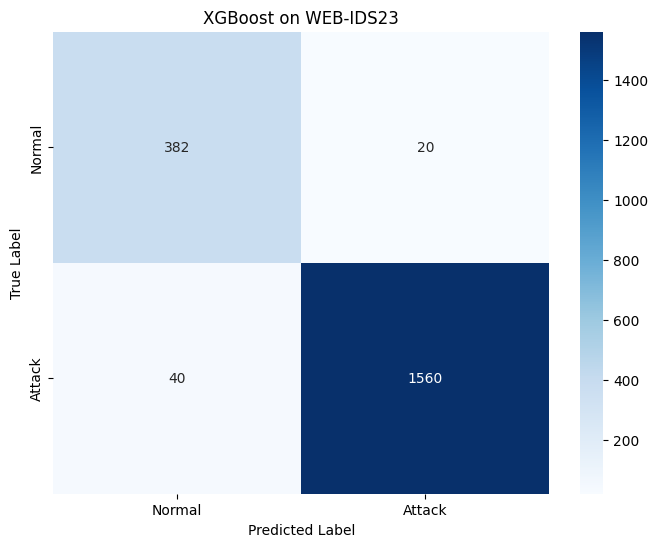

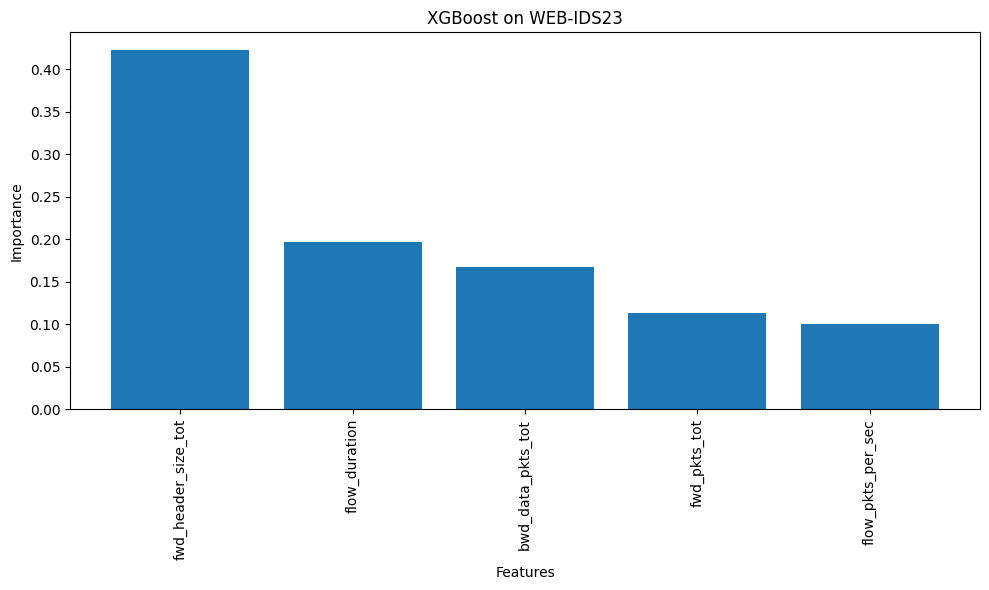

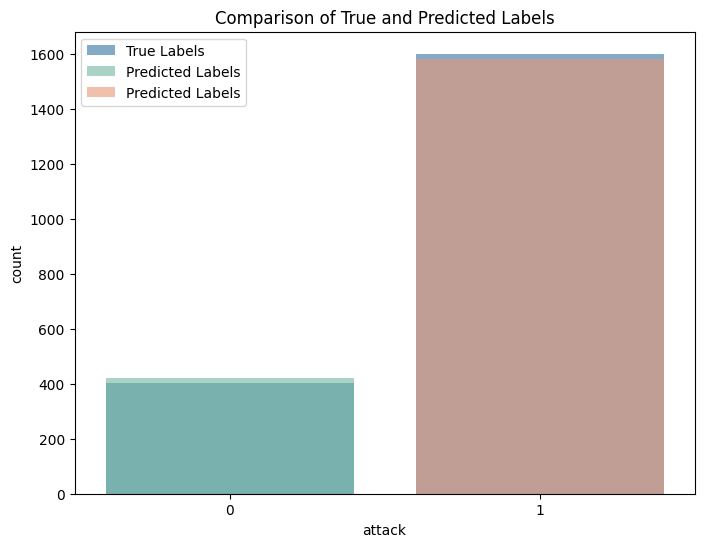

In [51]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("XGBoost on WEB-IDS23")
plt.show()

feature_importances = optimized_xgboost_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.title("XGBoost on WEB-IDS23")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x=y_test, label="True Labels", alpha=0.6)
sns.countplot(x=y_pred, label="Predicted Labels", alpha=0.6, palette="Set2")
plt.legend()
plt.title("Comparison of True and Predicted Labels")
plt.show()

In [52]:
optimized_xgboost_model.save_model("models\\xgboost_model_optuna.json")

In [53]:
del optimized_xgboost_model

## Test on CICID2017 dataset

In [54]:
#CICID2017
file_path = 'csv\\cicid2017.csv'
cicid = pd.read_csv(file_path)

c_list=[]

for c in cicid[' Label']:
    if c == 'BENIGN':
        c_list.append(1)
    else:
        c_list.append(0)

cicid[ ' Label'] = c_list

cicid = cicid.rename(columns={" Flow Duration": "flow_duration", 
                      " Flow Packets/s": "flow_pkts_per_sec",
                      " Total Backward Packets":"bwd_data_pkts_tot",
                      " Total Fwd Packets":"fwd_pkts_tot",
                      " Fwd Header Length":"fwd_header_size_tot",
                      " Label":"attack"})

features_cicid = [
    'flow_duration','flow_pkts_per_sec','bwd_data_pkts_tot', 'fwd_pkts_tot','fwd_header_size_tot'
]



X = cicid[features_cicid]
y = cicid['attack']

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)

y = y.loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

Accuracy: 0.5179237555225548
Confusion Matrix: [[  6892 126994]
 [ 10377 653576]]


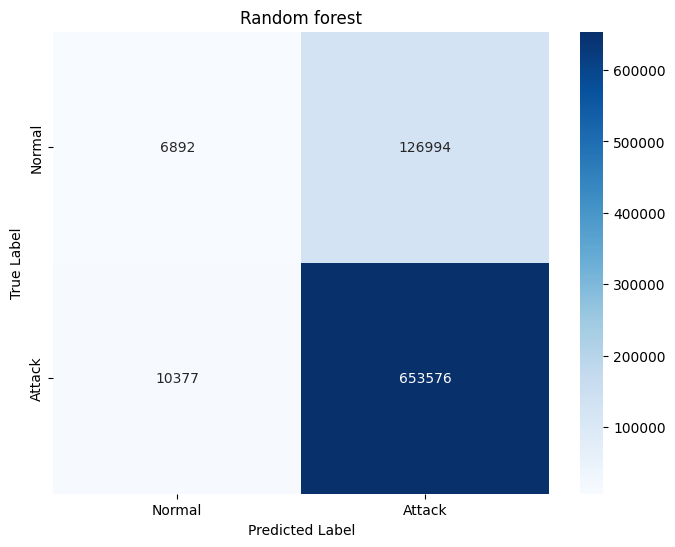

In [55]:
model=load("models\\rf_model.joblib")

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Random forest")
plt.show()

Accuracy: 0.5325107190276426
Confusion Matrix: [[ 25003 108883]
 [ 80821 583132]]


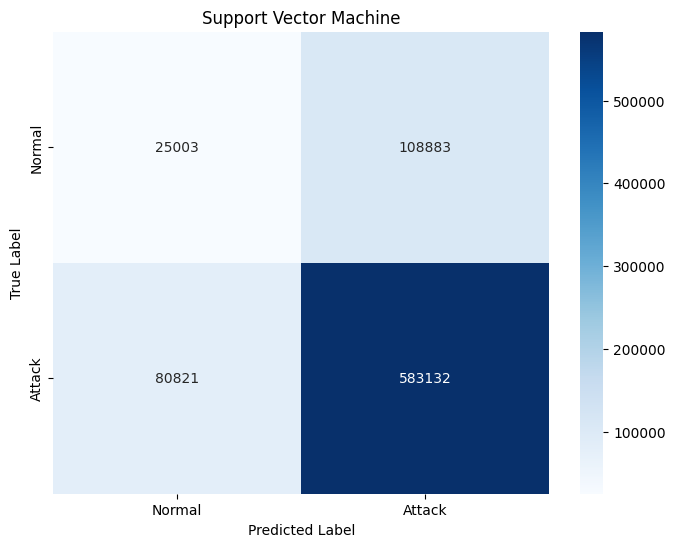

In [56]:
model=load("models\\svm_model.joblib")

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Support Vector Machine")
plt.show()

Accuracy: 0.5323613760989435
Confusion Matrix: [[ 21295 112591]
 [ 62631 601322]]


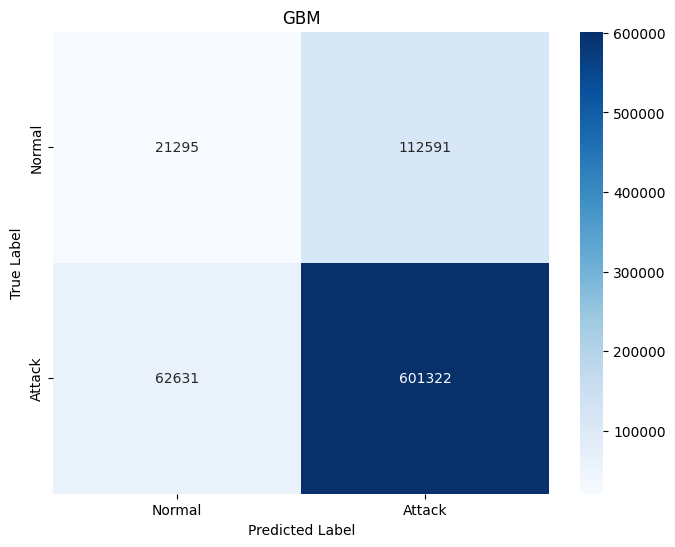

In [57]:
model=load("models\\gbm_model.joblib")

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("GBM")
plt.show()

Accuracy: 0.552788682176819
Confusion Matrix: [[ 22504 111382]
 [ 41501 622452]]


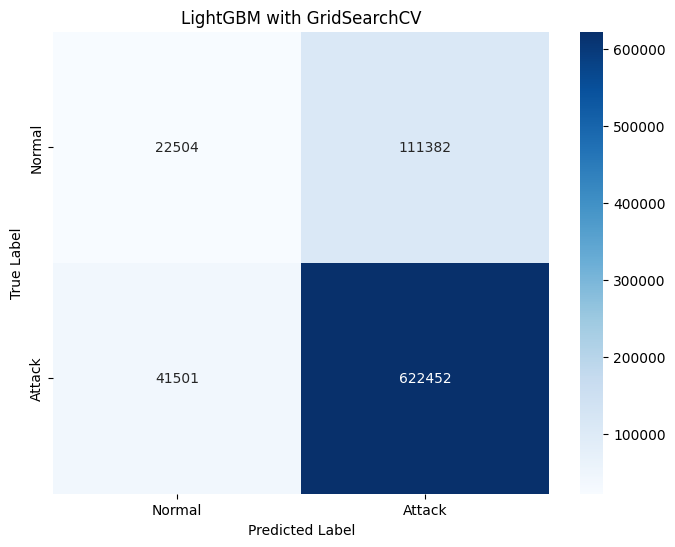

In [58]:
model=lgb.Booster(model_file="models\\lgb_model_gcv.txt")

y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int)
y_pred = y_pred_labels

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("LightGBM with GridSearchCV")
plt.show()

Accuracy: 0.5537054876764806
Confusion Matrix: [[ 22249 111637]
 [ 39019 624934]]


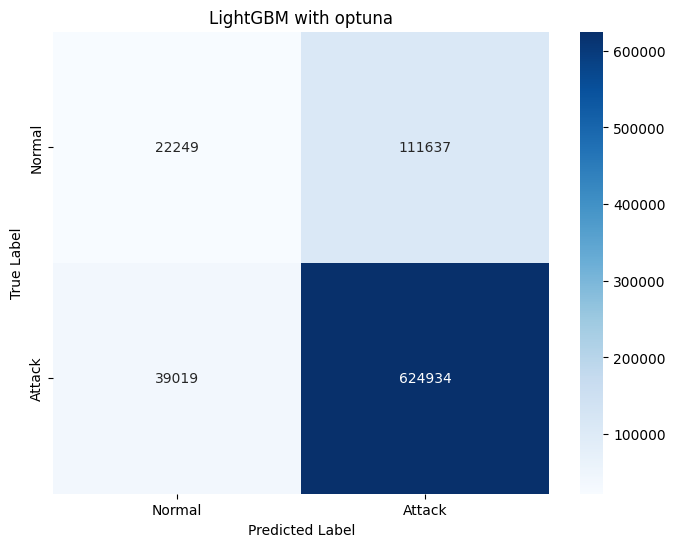

In [59]:
model=lgb.Booster(model_file="models\\lgb_model_optuna.txt")

y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int)
y_pred = y_pred_labels

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("LightGBM with optuna")
plt.show()

Accuracy: 0.4963885895394335
Confusion Matrix: [[    15 133871]
 [  4870 659083]]


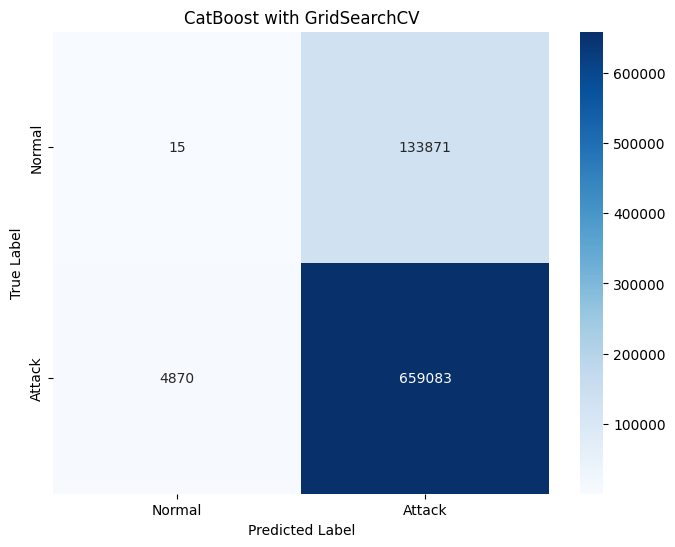

In [60]:
model = CatBoostClassifier()
model.load_model("models\\catboost_model_gcv.cbm")

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("CatBoost with GridSearchCV")
plt.show()

Accuracy: 0.5538736472270696
Confusion Matrix: [[ 22315 111571]
 [ 39123 624830]]


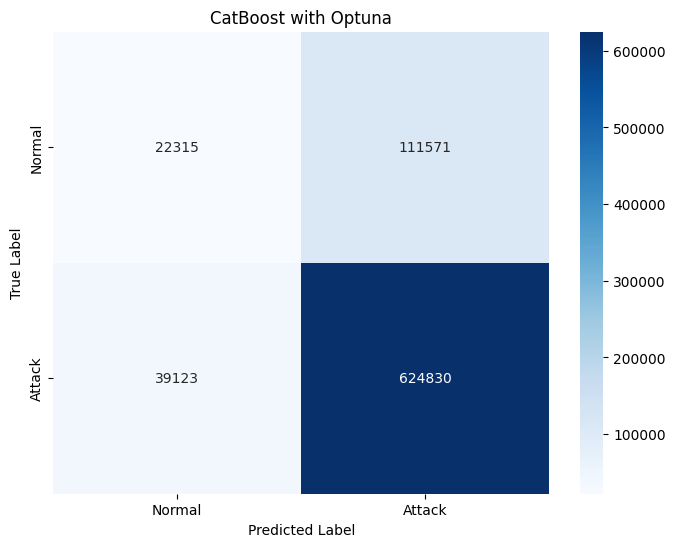

In [61]:
model = CatBoostClassifier()
model.load_model("models\\catboost_model_optuna.cbm")

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("CatBoost with Optuna")
plt.show()

Accuracy: 0.5536537390048916
Confusion Matrix: [[ 22951 110935]
 [ 42569 621384]]


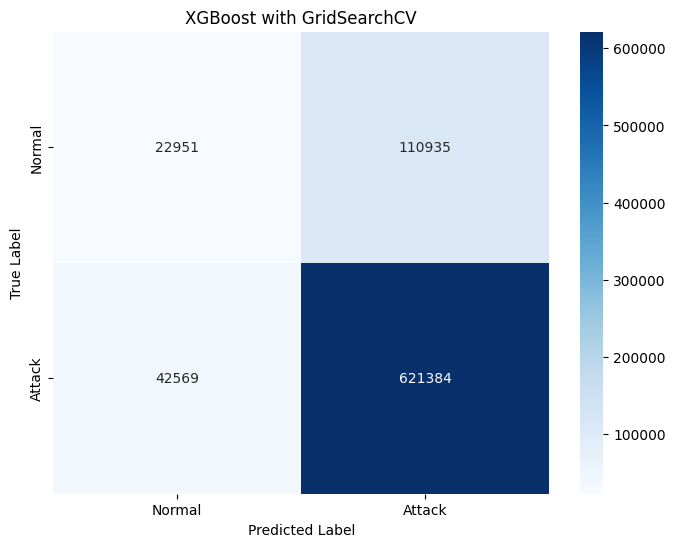

In [62]:
model = xgb()
model.load_model("models\\xgboost_model_gcv.json")

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("XGBoost with GridSearchCV")
plt.show()

Accuracy: 0.5288030328577311
Confusion Matrix: [[ 25332 108554]
 [ 87376 576577]]


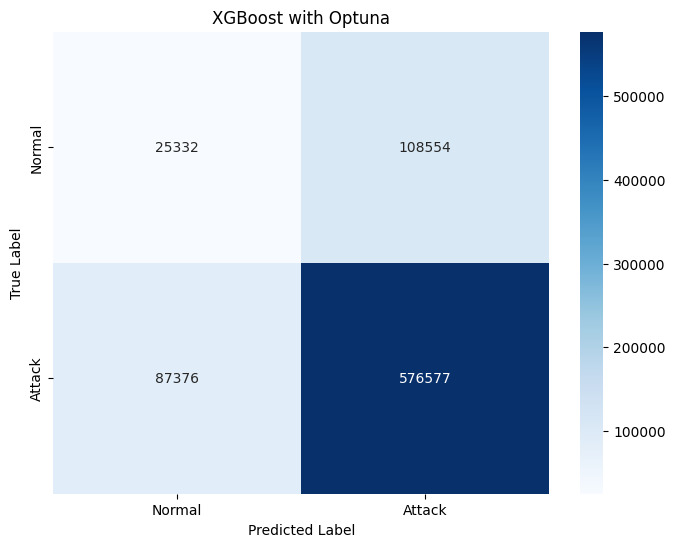

In [63]:
model = xgb()
model.load_model("models\\xgboost_model_optuna.json")

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:",conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("XGBoost with Optuna")
plt.show()